In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

# DM parameters are fixed throughout this analysis
from dm_params import mx, sv, fx
from utilities import e_low_excess, e_high_excess
from background_models import phi_g_egb_fermi
from finite_clump_vectorized import rho_s_dampe, luminosity, phi_g, phi_e, rho
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint
from finite_clump_vectorized import fermi_point_src_contraint, anisotropy_differential
from utilities import e_high_excess, bins_dampe
from utilities import fermi_psf, fermi_psf_solid_angle
from utilities import rho_max, dn_de_g_ap
from utilities import rho_earth, Hz_to_GeV2_cm3, GeV_to_m_sun, kpc_to_cm, t_universe
from utilities import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from utilities import colors, mantissa_exp, sci_fmt, log_levels
from utilities import normal_contours, sci_contours, log_contours

# Significance used for line width constraint
n_sigma = 3.
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Flux above which Fermi should observe the clump as an extended source
# phi_g_fermi_ext = 1e-7  # (GeV cm^2 s sr)^2
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

# NFW profile

In [2]:
# gamma_nfw = 0.5
gamma_nfw = 1.

dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/nfw_gamma_%.1f/' % gamma_nfw

## Load results

In [3]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "phi_g", "lw",
            "rho_s_fermi_ps", "phi_g_ext_rel"]:  #, "extent", "aniso_constr"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.loadtxt(
    pr_base_path + "nfw/nfw_gamma_%.2f.csv" % gamma_nfw,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_nfw = pr_nfw.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [75]:
rho_s_nfw = rho_s_dampe(dist_mg, r_s_mg, gamma_nfw, "nfw")

In [76]:
os.system("say 'Done computing rho'")

0

#### Checking results

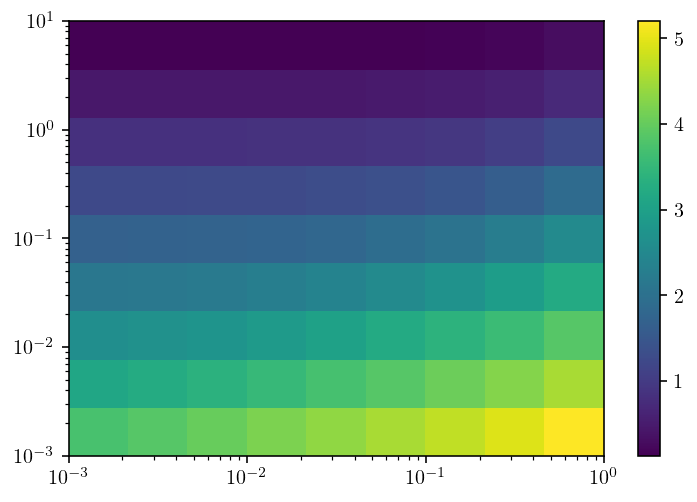

In [10]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_nfw))
plt.colorbar()

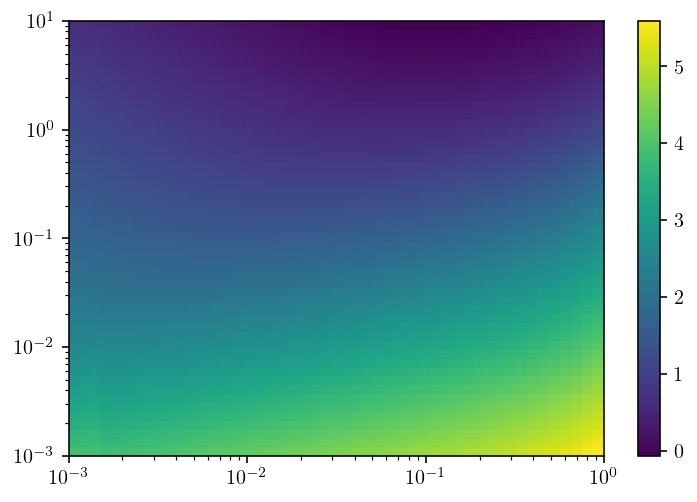

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_nfw))
plt.colorbar()

#### Fill `nan`s by linearly interpolating along the $r_s$ axis

In [4]:
from scipy.interpolate import interp1d

for i in range(3):
    obs_idx = np.where(~np.isnan(rho_s_nfw[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_nfw[obs_idx, i]), fill_value="extrapolate")
    
    nan_idx = np.where(np.isnan(rho_s_nfw[:, i]))[0]
    rho_s_nfw[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [77]:
rho_rel_nfw = (rho(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw") + rho_earth) / rho_earth

### $\mathcal{L}$

In [78]:
lum_nfw = luminosity(r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

### $J$

In [4]:
from finite_clump_vectorized import J_factor
J_nfw = J_factor(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", fermi_psf)

#### Plot results

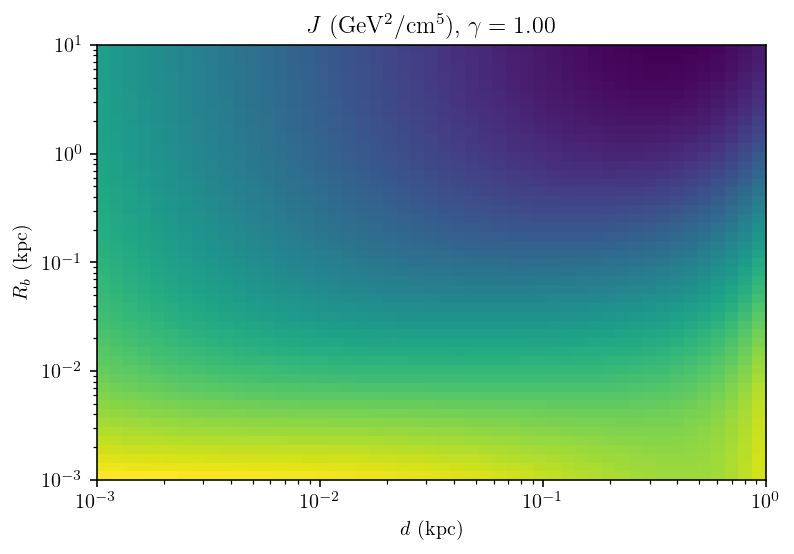

In [5]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$J$ (GeV$^2$/cm$^5$), $\gamma=%.2f$" % gamma_nfw)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")

plt.pcolormesh(dist_mg, r_s_mg, np.log10(J_nfw))
# sci_contours(dist_mg, r_s_mg, J_nfw, plt.gca())
# plt.savefig("/Users/acoogan/Desktop/J_exp_1_08.pdf")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [6]:
phi_g_nfw = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", fermi_psf)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw",
                              e_gamma_ref, thresh=0.68)

### Line width constraint

In [80]:
lw_nfw = line_width_constraint(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", n_sigma)

In [81]:
os.system("say 'Done computing line width constraint'")

0

### Fermi point source non-detection constraint

In [7]:
rho_s_fermi_ps_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw")

In [83]:
os.system("say 'Done computing point source constraint'")

0

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [8]:
th_ref = 1. * np.pi / 180  # 1 degree
phi_g_ext_nfw = phi_g(0.99*e_high_excess, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", th_ref)
phi_g_ext_rel_nfw = phi_g_ext_nfw / phi_g_egb_fermi(e_high_excess)

In [85]:
os.system("say 'Done computing extended source constraint'")

0

#### Comparing definitions of the constraint

In [20]:
def phi_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [27]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
phi_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

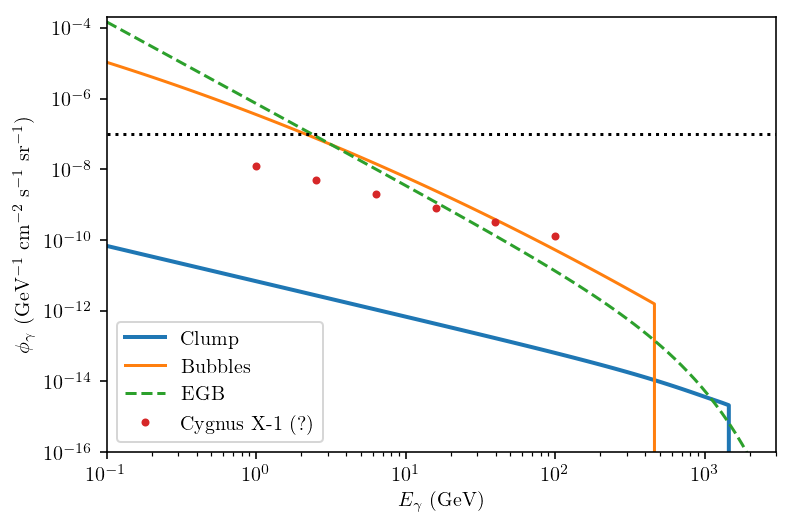

In [36]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, phi_g(e_gs, 1e-2, 1e-2, 1e3, gamma_nfw, "nfw", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, phi_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, dphi_de_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, phi_g_cyg, '.', label="Cygnus X-1 (?)")
plt.axhline(1e-7, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [20]:
aniso_diff_nfw = anisotropy_differential(0.99*e_high_excess, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

In [51]:
from utilities import D, speed_of_light, lambda_prop, kpc_to_cm
from pointlike_clump import dphi_de_e_dampe_pt, dphi_de_e_pt, lum_dampe_pt
from background_models import phi_e_bg_dampe

def aniso_pt(e, dist):
    lum = lum_dampe_pt(dist)
    
    def _aniso_pt(e):
        if e < mx:
            return (3 * D(e) / speed_of_light * 2 * dist / lambda_prop(e, mx) *
                    dphi_de_e_pt(e, dist, mx, lum) / phi_e_bg_dampe(e) * kpc_to_cm)
        else:
            return 0.
    
    return np.vectorize(_aniso_pt)(e)

ImportError: cannot import name bg_dampe

Text(0.5,1,'$d = 10^{-1}$ kpc, $\\gamma_{\\mathrm{NFW}} = 1.00$')

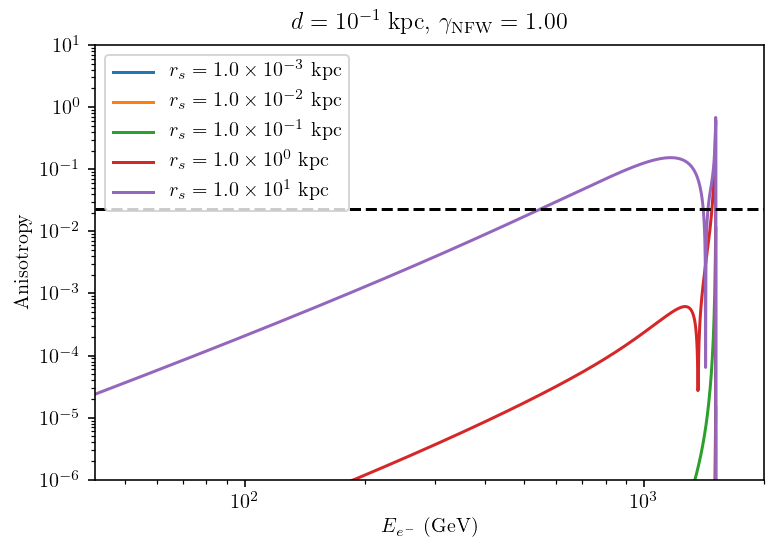

In [49]:
gamma_nfw = 1.

es = np.linspace(e_low_aniso_fermi[0], np.min([mx, e_high_aniso_fermi[-1]]), 500)
dist = 1e-1
rho_s_val = rho_s_dampe(dist, 1e0, gamma=gamma_nfw, halo="nfw")

for r_s in np.logspace(-3, 1, 5):
    plt.loglog(es,
               anisotropy_differential(es, dist, r_s, rho_s=rho_s_val,
                                       gamma=gamma_nfw, halo="nfw", delta_d_rel=1e-6),
               label=r"$r_s = %.1f \times 10^{%i}$ kpc" % mantissa_exp(r_s))
    
plt.axhline(aniso_fermi[-1], linestyle='--', color='k')

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(e_low_aniso_fermi[0], e_high_aniso_fermi[-1])
plt.ylim(1e-6, 1e1)
plt.xlabel(r"$E_{e^-}$ (GeV)")
plt.ylabel(r"Anisotropy")
plt.title(r"$d = 10^{%i}$ kpc, $\gamma_{\mathrm{NFW}} = %.2f$" % (np.log10(dist), gamma_nfw))
# plt.savefig("figures/aniso_diff_nfw_d=%.2f_gamma=0.5.pdf" % dist)

Text(0,0.5,'$r_s$ (kpc)')

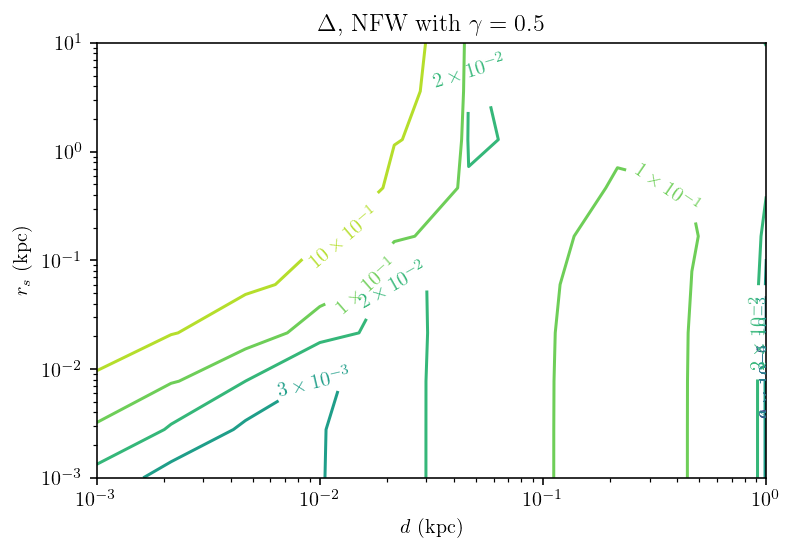

In [21]:
plt.xscale("log")
plt.yscale("log")

sci_contours(dist_mg, r_s_mg, aniso_diff_nfw, plt.gca())

plt.title(r"$\Delta$, NFW with $\gamma=%.1f$" % gamma_nfw)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")

Text(0,0.5,'$r_s$ (kpc)')

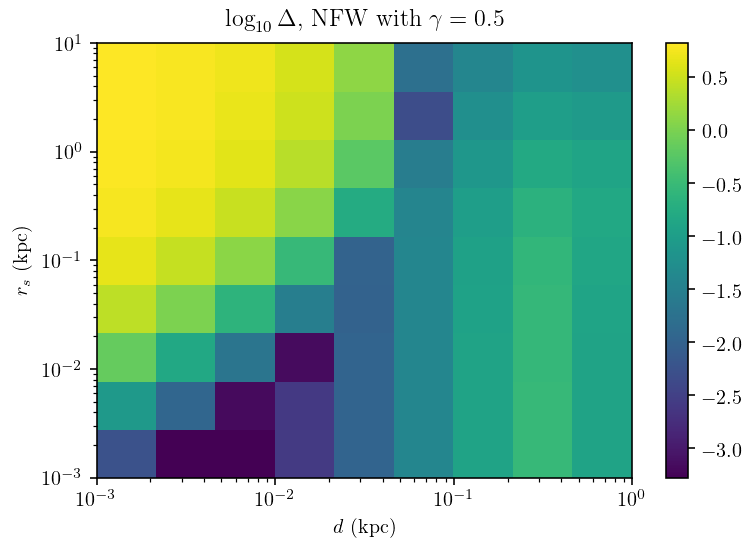

In [22]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(aniso_diff_nfw))
plt.colorbar()

plt.title(r"$\log_{10}\Delta$, NFW with $\gamma=%.1f$" % gamma_nfw)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")

## Save results

In [9]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "phi_g", "lw",
            "rho_s_fermi_ps", "phi_g_ext_rel"]:#, "extent", "aniso_constr"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

## Plot everything together

In [10]:
levels_nfw = {"lum": [1e31, 2e31, 7e31, 2e32, 5e32, 2e33, 4e33, 1e34, 4e34],
              "rho_s": [1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4],
              "phi_g": [5e-17, 1e-16, 3e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13, 1e-12, 1e-10, 1e-8],
              "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
              "extent": [2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550]}

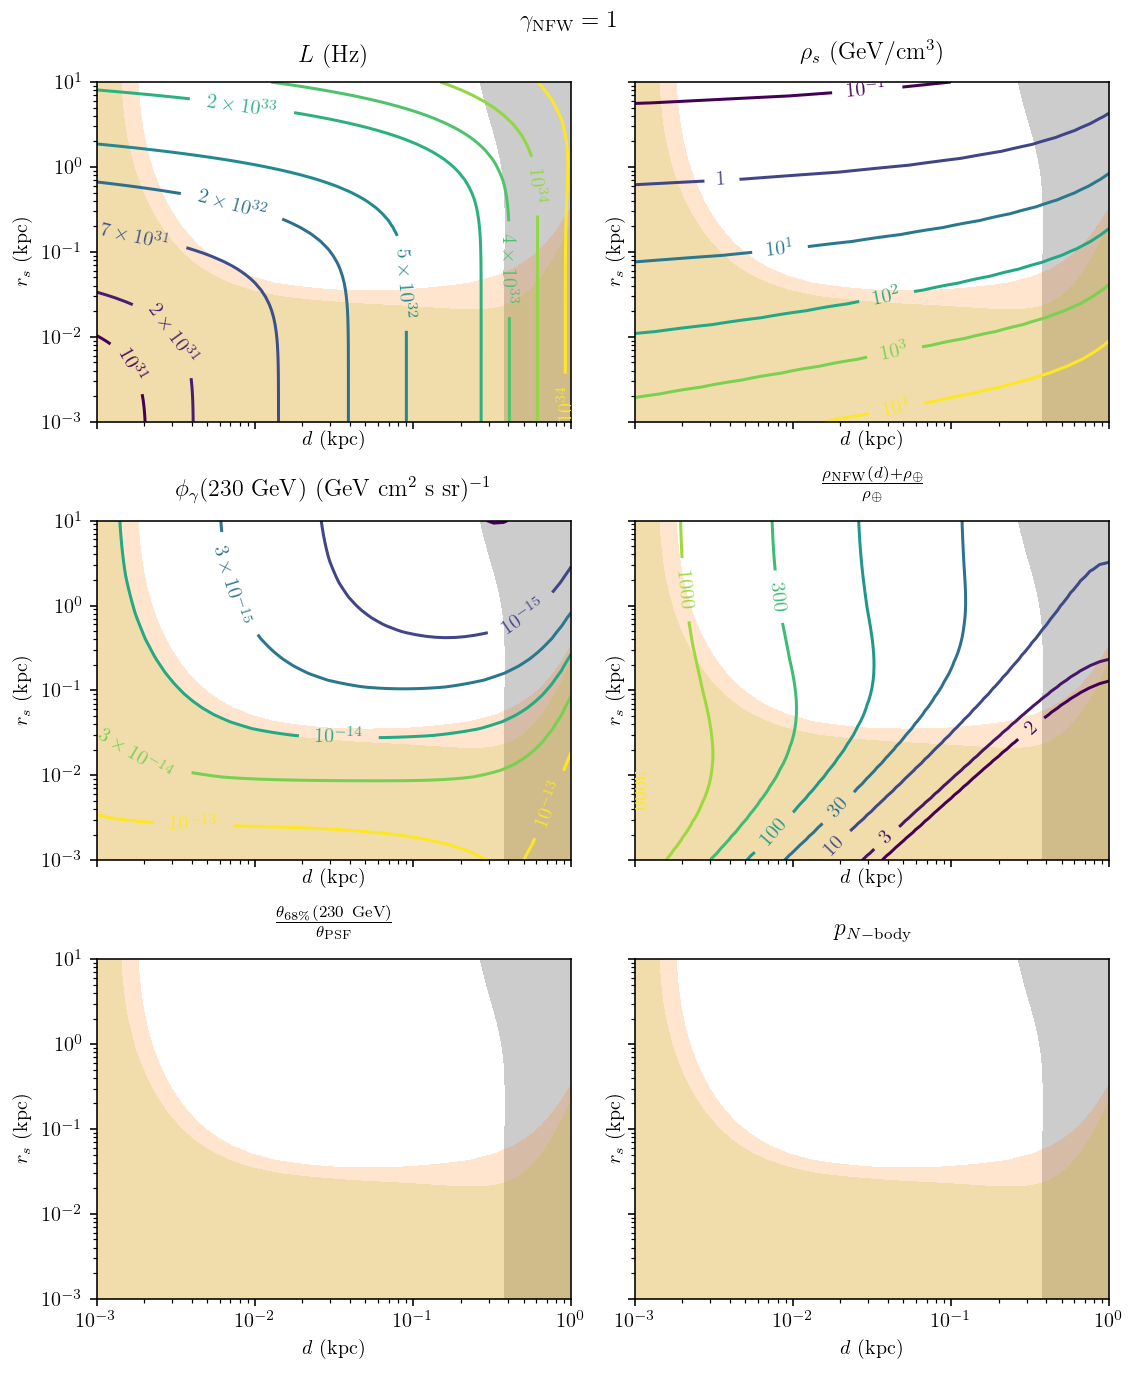

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

if gamma_nfw == 1:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.0f}".format(gamma_nfw) + r"$")
elif gamma_nfw == 0.5:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.1f}".format(gamma_nfw) + r"$")

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_s_mg, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, phi_g_ext_rel_nfw, levels=[1e1, 1e100],
                colors=[colors[8]], alpha=0.2)
    # Anisotropy constraint
#     ax.contourf(dist_mg, r_s_mg, aniso_constr_nfw, levels=[1e0, 1e100], colors=[colors[0]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_nfw, ax, levels=levels_nfw["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV/cm$^3$)", pad=10)
sci_contours(dist_mg, r_s_mg, rho_s_nfw, ax, levels=levels_nfw["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, phi_g_nfw, ax, levels=levels_nfw["phi_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_nfw, ax, levels=levels_nfw["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
# normal_contours(dist_mg, r_s_mg, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N {\rm -body}}$", pad=10)
# if gamma_nfw == 0.5:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-15, -12, 4))
# elif gamma_nfw == 1:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-13, -7, 7))


fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_{:.1f}.pdf".format(gamma_nfw))

In [89]:
os.system("say 'Done with NFW'")

0

## Ironing out the $\theta_{68\%}$ noise

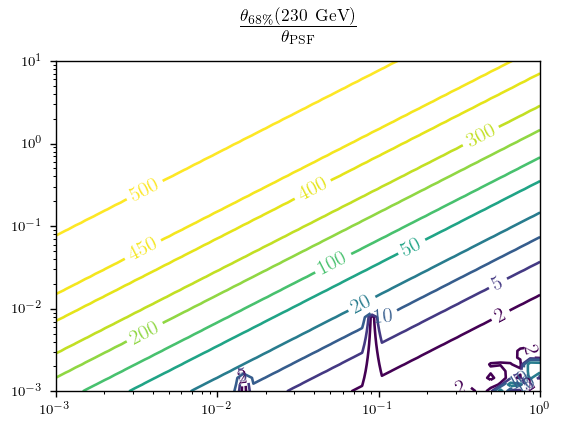

In [37]:
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)

normal_contours(dist, r_s, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

# smoothed_extents = np.exp(gaussian_filter(np.log10(extent_nfw), sigma=5))
# normal_contours(dist, r_s, smoothed_extents/fermi_psf, ax, levels=levels_nfw["extent"])

In [30]:
smoothed_extents[smoothed_extents / extent_nfw]

array([[  1.76159652,   1.98282756,   2.2155379 , ...,  37.03714411,
        122.68687276,  56.16316236],
       [  1.51652218,   1.69066672,   1.87457438, ...,   1.76359333,
         36.49534073, 115.515198  ],
       [  1.34372372,   1.48159936,   1.62742278, ...,  31.83759686,
          1.72756092,  36.08166807],
       ...,
       [  0.84002747,   0.84008582,   0.84013985, ...,   0.9364853 ,
          0.95565902,   0.98073426],
       [  0.83998159,   0.84002899,   0.84007178, ...,   0.91717511,
          0.93294833,   0.95367318],
       [  0.83993091,   0.83996865,   0.84000104, ...,   0.89812564,
          0.91094992,   0.92802663]])

In [19]:
from scipy.ndimage.filters import gaussian_filter

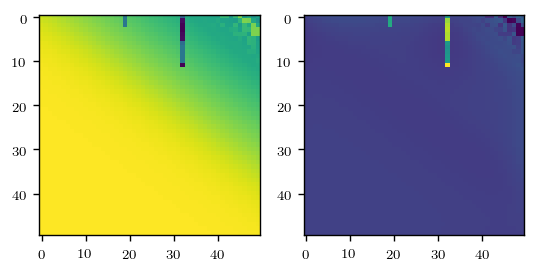

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(np.log10(extent_nfw/fermi_psf))

plt.subplot(1, 2, 2)
plt.imshow(gaussian_filter(np.log10(extent_nfw/fermi_psf), sigma=5))

In [41]:
from scipy.interpolate import interp1d

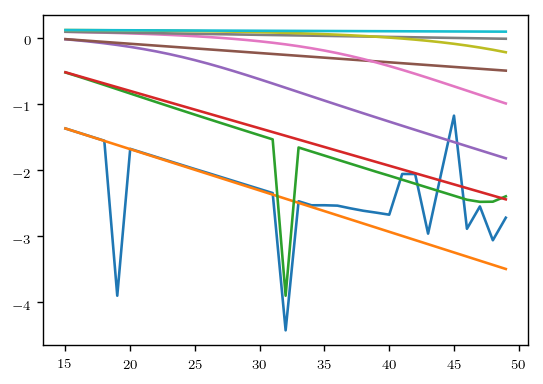

In [50]:
for i in range(extent_nfw.shape[0])[::10]:
    d_obs = np.arange(15)
    interp = interp1d(d_obs, np.log10(extent_nfw)[i, :d_obs.size],
                      fill_value="extrapolate")
    
    d_extrap = np.arange(d_obs.size, extent_nfw.shape[1])
    plt.plot(d_extrap, np.log10(extent_nfw)[i, d_obs.size:])
    plt.plot(d_extrap, interp(d_extrap))

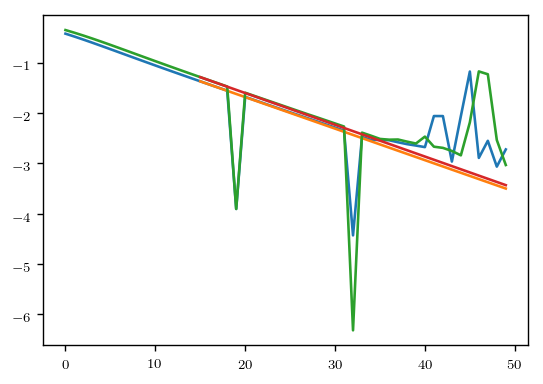

In [45]:
for i in [0, 1]:
    plt.plot(np.log10(extent_nfw)[i, :])
    interp = interp1d(range(15), np.log10(extent_nfw)[i, :15], fill_value="extrapolate")
    plt.plot(range(15, 50), interp(range(15, 50)))

# smoothed_extents = gaussian_filter(extent_nfw, sigma=2)
# plt.plot(np.log10(smoothed_extents)[0, :])
# plt.plot(np.log10(smoothed_extents)[1, :])

# Exponential/tidally truncated profile

In [28]:
# gamma_exp = 0.52  # 25th percentile
# gamma_exp = 0.74  # median
gamma_exp = 1.08  # 75th percentile
# gamma_exp = 2.25  # 9/4, the UCMH power law
# gamma_exp = 1.2  # the steepest inner slope this code works with is ~1.2

# Tightening up the plane (default: 50 points along each axis)
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_exp = 'data/exp_gamma_%.2f/' % gamma_exp

## Load results

In [6]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "phi_g",
            "lw", "rho_s_fermi_ps", "phi_g_ext_rel"]:  #, "extent", "aniso_constr"]:
    exec(var + "_exp = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_exp = np.loadtxt(
    pr_base_path + "exp/exp_gamma_%.2f.csv" % gamma_exp,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_exp = pr_exp.reshape(dist_pr.shape)

## Recompute

### Exploring numerical issues

* Prohibitively slow to incorporate the annihilation plateau into finding $\rho_s$ since that'd require using a root finder.
* Spectrum is hard to compute when $r_s / d$ is small.

In [3]:
from exp_clump import dphi_e_dr as dphi_e_dr_exp

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


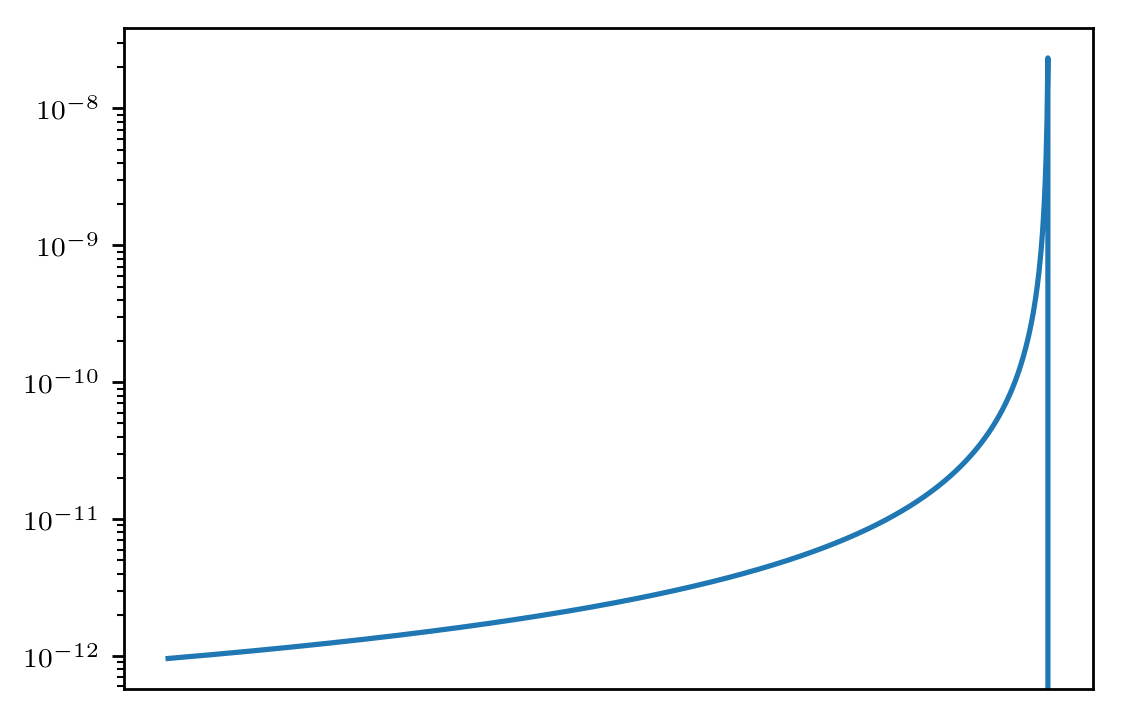

In [4]:
es = np.logspace(np.log10(e_low_excess), np.log10(mx), 1000)

dist, r_s = (0.0026826957952797246, 0.001)

plt.loglog(es, phi_e(es, dist, r_s, 1e5, gamma_exp, "exp"))

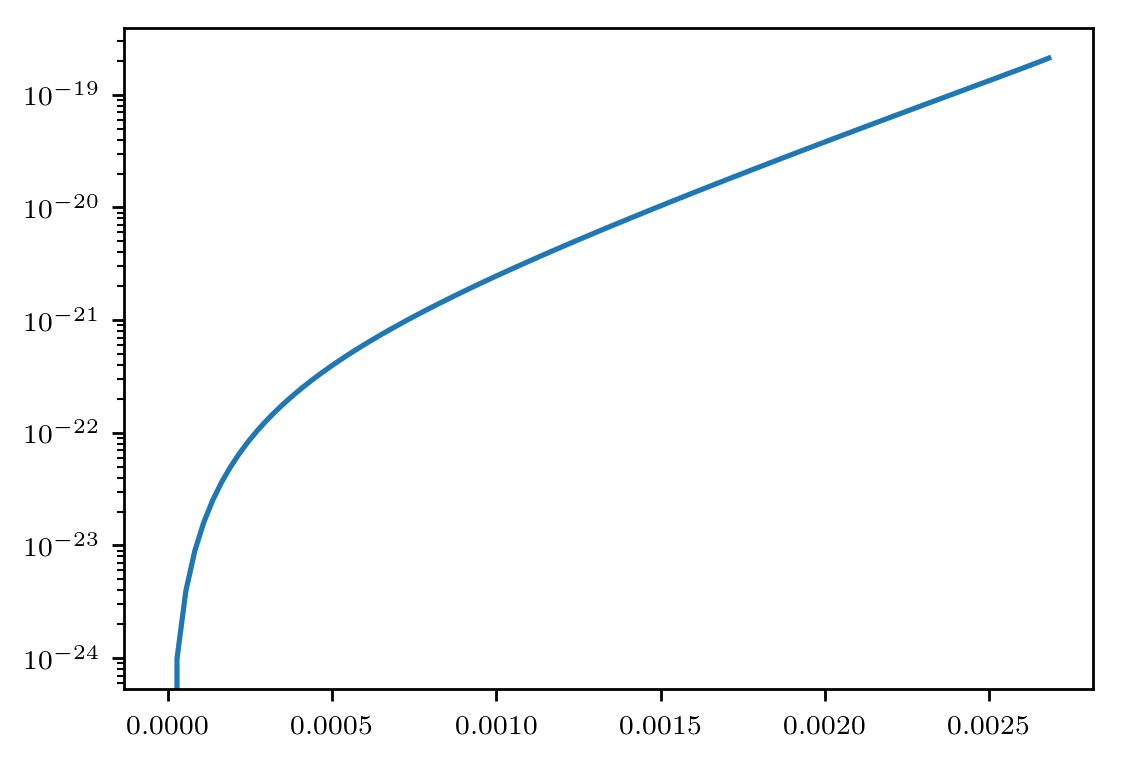

In [5]:
dist, r_s = (0.0026826957952797246, 0.001)
gamma_exp = 0.52
rs = np.linspace(0., dist, 100)

plt.plot(rs, np.vectorize(dphi_e_dr_exp)(rs, 1400, dist, r_s, 1., gamma_exp, mx, sv, fx))
plt.yscale("log")
# plt.ylim(1e-35, 1e-15)

### $\rho_s$

In [29]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp, "exp")

In [30]:
os.system("say 'Computed normalization'")

0

#### Plot results

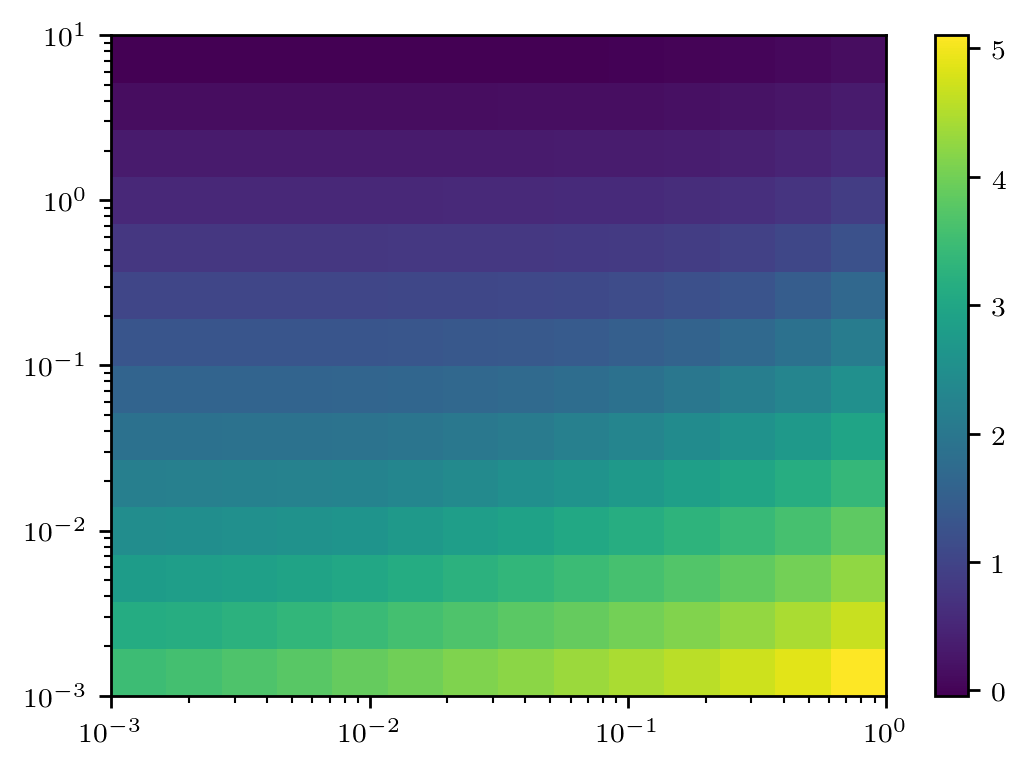

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_exp))
plt.colorbar()

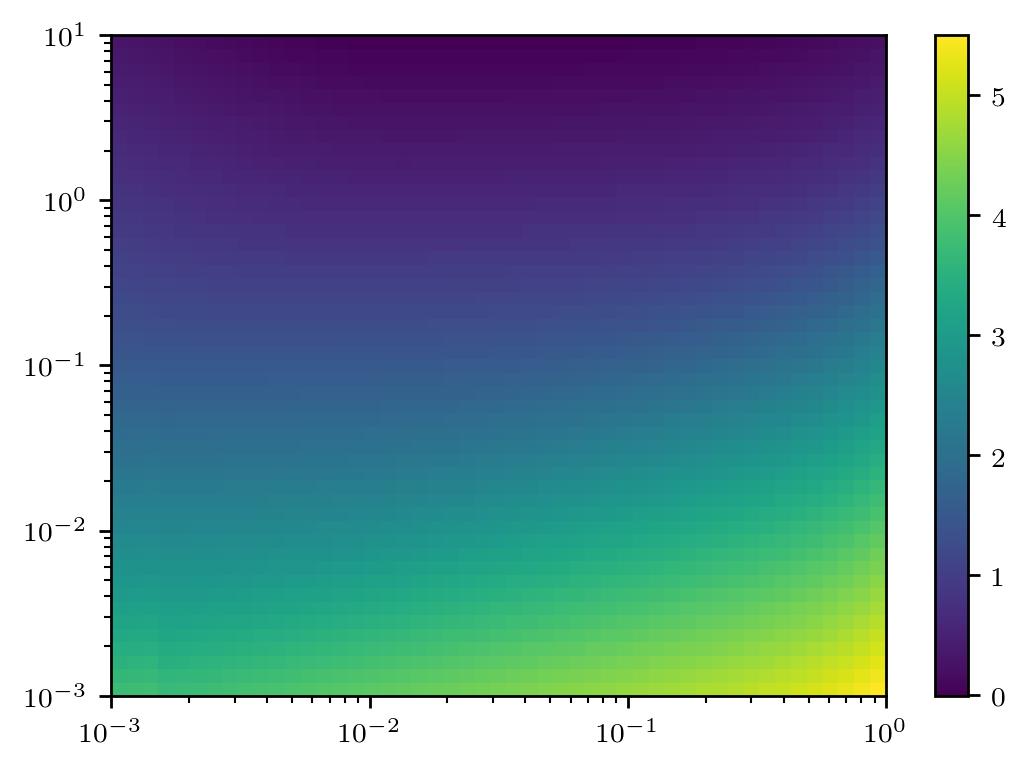

In [10]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_exp))
plt.colorbar()

#### Interpolate numerical glitches

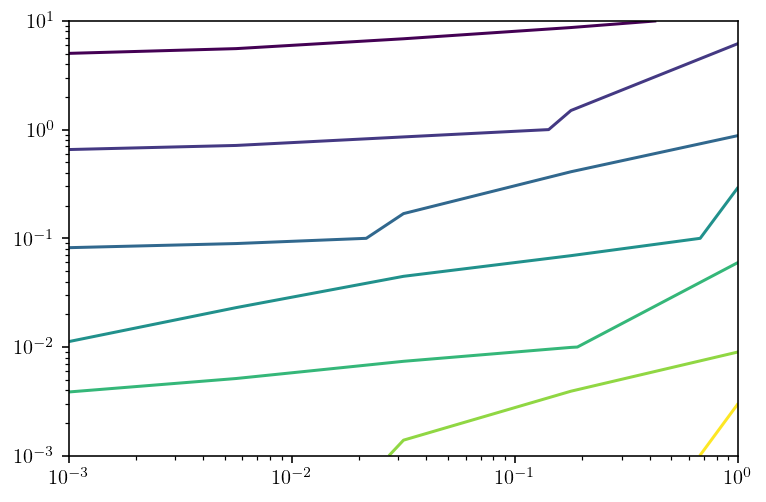

In [25]:
plt.xscale("log")
plt.yscale("log")
plt.contour(dist, r_s, np.log10(rho_s_exp))

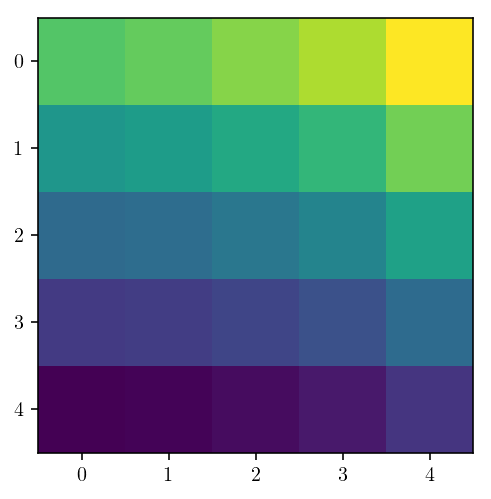

In [26]:
plt.imshow(np.log10(rho_s_exp))

#### Linearly interpolate nans

In [26]:
from scipy.interpolate import interp1d

for i in range(10, 15):
    obs_idx = np.where(~np.isnan(rho_s_exp[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_exp[obs_idx, i]),
                      fill_value="extrapolate")    
    nan_idx = np.where(np.isnan(rho_s_exp[:, i]))[0]
    rho_s_exp[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [31]:
rho_rel_exp = (rho(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp") + rho_earth) / rho_earth

### $\mathcal{L}$

In [32]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp, "exp")

### $J$

In [19]:
# from finite_clump_vectorized import J_factor
# J_exp = J_factor(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", fermi_psf)

#### Plot results

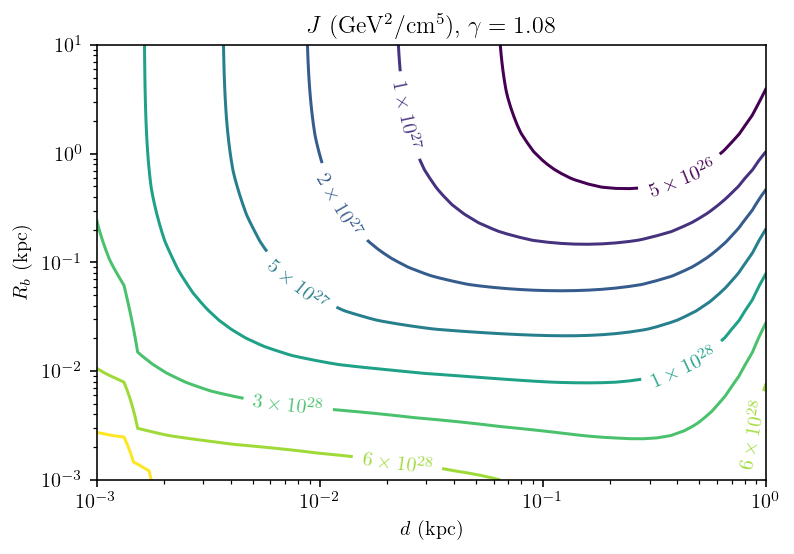

In [33]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$J$ (GeV$^2$/cm$^5$), $\gamma=1.08$")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")

sci_contours(dist_mg, r_s_mg, J_exp, plt.gca())
plt.savefig("/Users/acoogan/Desktop/J_exp_1_08.pdf")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [33]:
phi_g_exp = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", fermi_psf)

In [34]:
os.system("say 'Computed photon flux'")

0

#### Annihilation plateau

In [ ]:
# from tt_clump import ann_plateau_radius as ann_plateau_radius_exp

# r_p_mg = ann_plateau_radius_exp(r_s_mg, rho_s_exp, gamma_exp)
# J_plateau_exp = 2*r_p_mg*rho_max**2*kpc_to_cm
# phi_g_exp = (fermi_psf_solid_angle/4/np.pi * 3e-26/2 / dampe_excess_bin_high**2 *
#                  dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) * J_plateau_exp)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
# extent_exp = gamma_ray_extent(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp",
#                               e_gamma_ref, thresh=0.68)

#### Ironing out the noise

In [31]:
extent_exp_coarse = gamma_ray_extent(dist_mg[::3, ::3], r_s_mg[::3, ::3],
                                     rho_s_exp[::3, ::3], gamma_exp, "exp",
                                     e_gamma_ref, thresh=0.68)

NameError: name 'levels_exp' is not defined

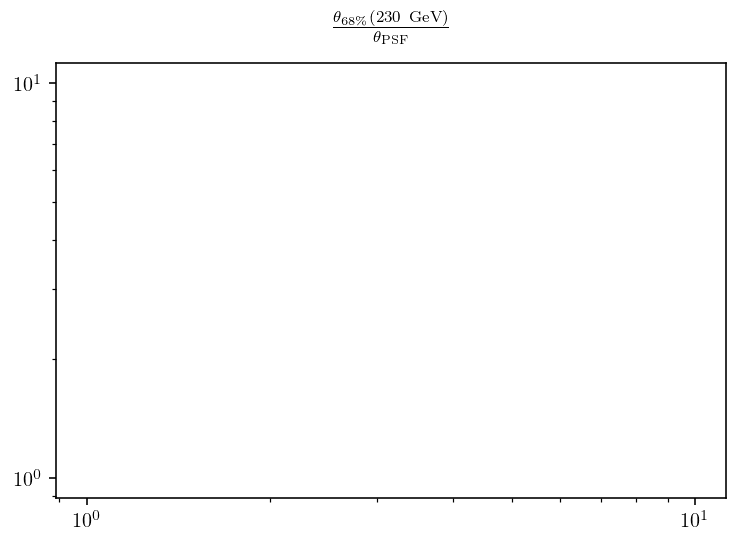

In [32]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)

plt.contour(dist[::3], r_s[::3], extent_exp_coarse/fermi_psf,
            levels=levels_exp[gamma_exp]["extent"])

In [ ]:
os.system("say 'Done'")

### Line width constraint

In [35]:
lw_exp = line_width_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", n_sigma)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)


In [36]:
os.system("say 'Computed line width constraint'")

0

### Fermi point source non-detection constraint

In [37]:
rho_s_fermi_ps_exp = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_exp, "exp")

In [38]:
os.system("say 'Computed point source constraint'")

0

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [40]:
th_ref = 1. * np.pi / 180  # 1 degree
phi_g_ext_exp = phi_g(0.99*e_high_excess, dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", th_ref)
phi_g_ext_rel_exp = phi_g_ext_exp / phi_g_egb_fermi(e_high_excess)

In [39]:
os.system("say 'Computed extended source constraint'")

0

#### Comparing definitions of the constraint

In [4]:
def phi_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [5]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
phi_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

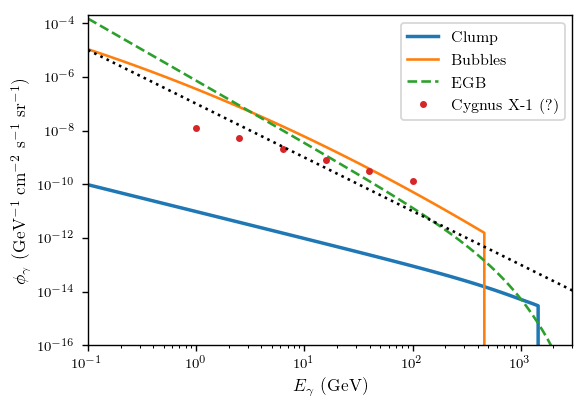

In [10]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, phi_g(e_gs, 1e-2, 1e-2, 1e3, gamma_exp, "exp", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, phi_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, dphi_de_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, phi_g_cyg, '.', label="Cygnus X-1 (?)")
plt.loglog(e_gs, 1e-7 / e_gs**2, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [11]:
# aniso_constr_exp = anisotropy_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", bg_dampe)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: divide by zero encountered in _helper (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _helper (vectorized)
  outputs = ufunc(*inputs)


## Save results

In [41]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "phi_g",  # "extent",
            "lw", "rho_s_fermi_ps", "phi_g_ext_rel"]:#, "aniso_constr"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var + "_exp"), delimiter=',')

## Plot everything together

In [48]:
levels_exp = {}
levels_exp[0.52] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34, 1e35],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [3e-18, 1e-17, 1e-16, 1e-15, 1e-14],
                    "rho_rel": [2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[0.74] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [1e-16, 5e-16, 1e-15, 3e-15, 1e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[1.08] = {"lum": [1e31, 3e31, 1e32, 3e32, 1e33, 3e33, 7e33],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [6e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13],
                    "rho_rel": [1.1, 2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[1.2] = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [1e-16, 5e-16, 1e-15, 3e-15, 1e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}

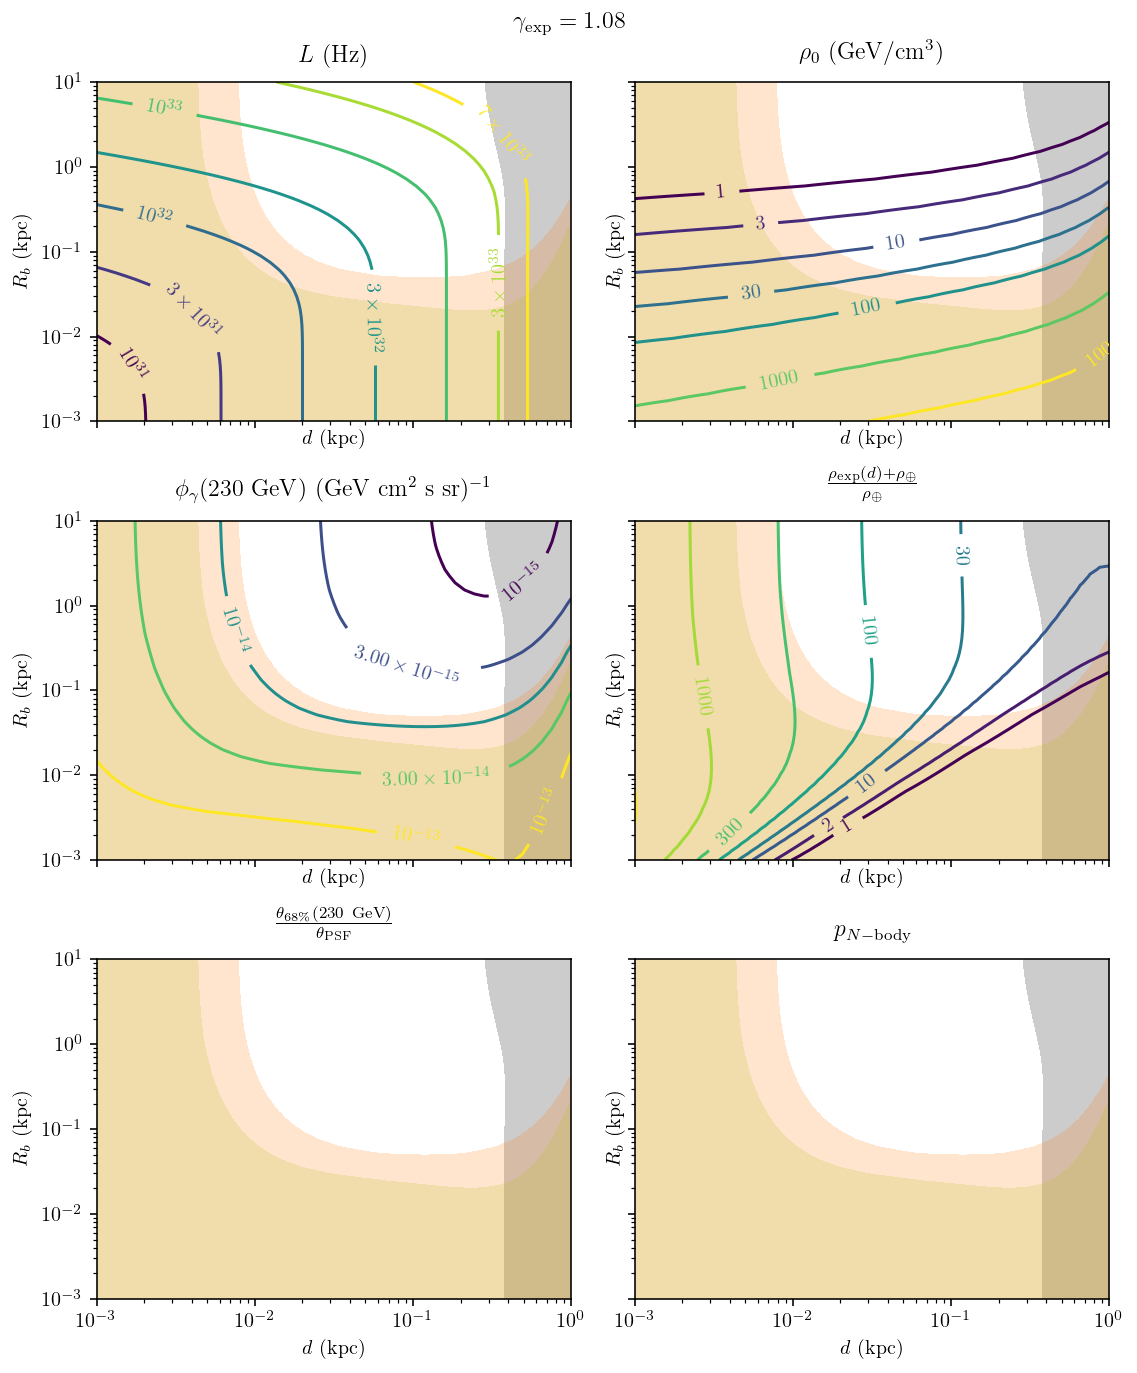

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

fig.suptitle(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma_exp)

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$R_b$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_s_mg, lw_exp, levels=[n_sigma, np.max(lw_exp)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_exp - rho_s_exp, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, phi_g_ext_rel_exp, levels=[1e1, 1e100],
                colors=[colors[8]], alpha=0.2)
#     # Anisotropy constraint
#     ax.contourf(dist_mg, r_s_mg, aniso_constr_exp, levels=[1e0, 1e100], colors=[colors[0]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_exp, ax, levels=levels_exp[gamma_exp]["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_0$ (GeV/cm$^3$)", pad=10)
normal_contours(dist_mg, r_s_mg, rho_s_exp, ax, levels=levels_exp[gamma_exp]["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, phi_g_exp, ax, fmt="0.2f", levels=levels_exp[gamma_exp]["phi_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{exp}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_exp, ax, levels=levels_exp[gamma_exp]["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
# normal_contours(dist_mg, r_s_mg, extent_exp/fermi_psf, ax,
#                 levels=levels_exp[gamma_exp]["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N{\rm -body}}$", pad=10)
# log_contours(dist_pr, r_s_pr, pr_exp, ax, levels=np.logspace(-9, -4, num=6))

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
# fig.savefig("figures/contour_plots_exp_gamma_%.2f.pdf" % gamma_exp)

In [44]:
os.system("say 'Done with exp profile'")

0

## Debugging

Annihilation plateau radius

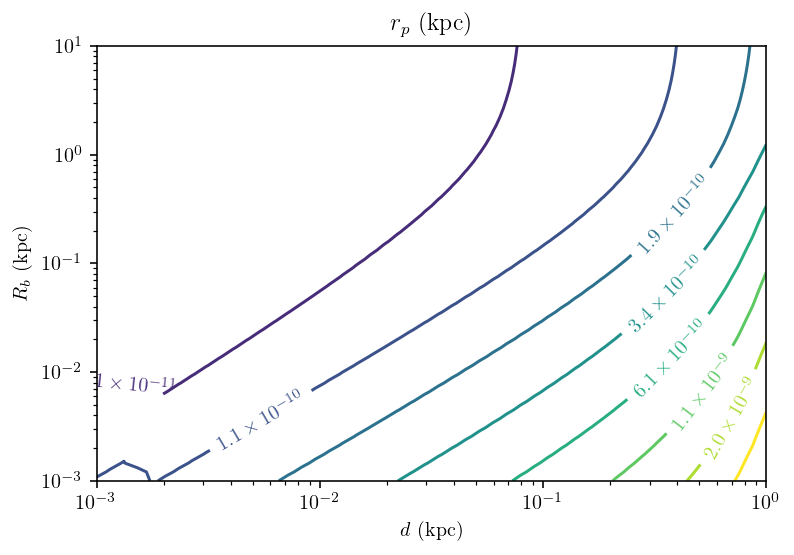

In [85]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$r_p$ (kpc)")

r_p_mg = ann_plateau_radius_exp(r_s_mg, rho_s_exp, gamma_exp)
sci_contours(dist_mg, r_s_mg, r_p_mg, plt.gca(), log_levels(r_p_mg), fmt="0.1f")

Comparing luminosities for exponential clump: plateau only, power law, full result. They all match reasonably well.

In [91]:
3e-26 / (2*dampe_excess_bin_high**2) * 4./3.*np.pi*(1e-10*kpc_to_cm)**3 * rho_max**2

1.0877219238817702e+25

In [95]:
lum_pl(1e-10, 0.1, 1.08)

1.4104569729363806e+33

In [96]:
luminosity(0.1, 10., 1.08, "exp")

array(1.51584676e+32)

Looks like it's correct. Also below: comparison with power law.

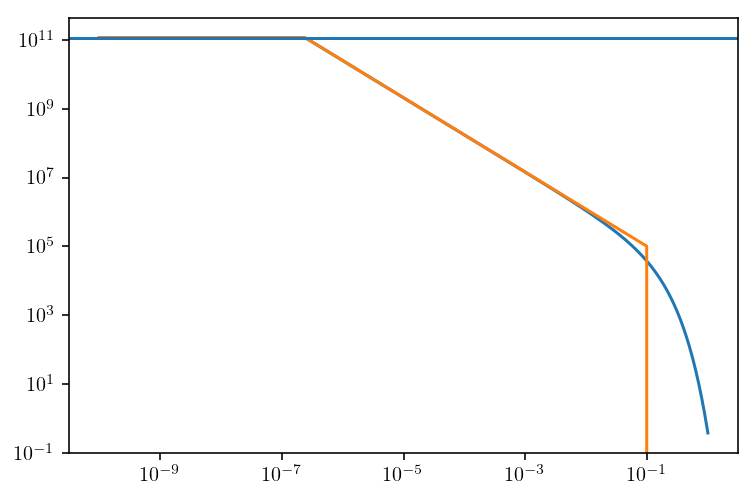

In [90]:
rs = np.logspace(-10, 0, 200)

r_p = ann_plateau_radius_exp(0.1, 1e5, gamma_exp)

plt.loglog(rs, rho(rs, 0.1, 1e5, gamma_exp, "exp"))
plt.loglog(rs, rho_pl(rs, r_p, 0.1, gamma_exp))
plt.axhline(rho_max)

$J$-factor: exponential clump

In [31]:
from finite_clump_vectorized import J_factor

In [83]:
th_max = fermi_psf
dOmega = 2.*np.pi*(1. - np.cos(th_max))
J_exp = J_factor(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", th_max)

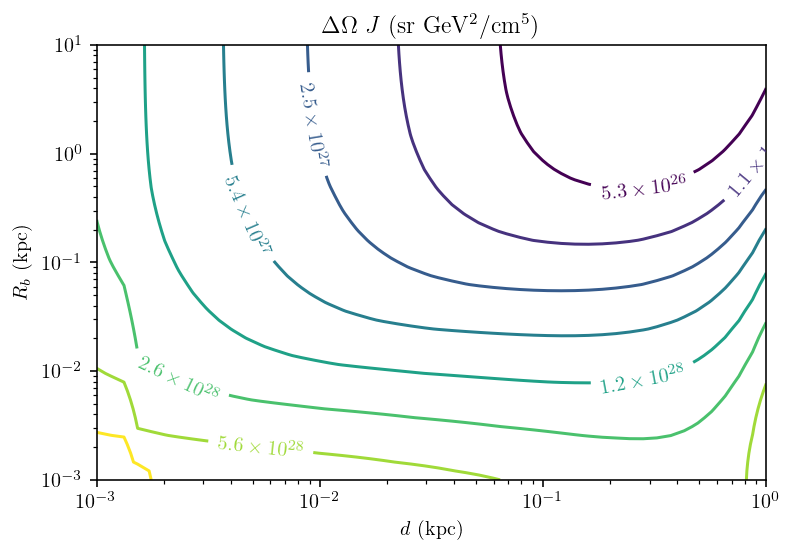

In [89]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$\Delta \Omega ~ J$ (sr GeV$^2$/cm$^5$)")

sci_contours(dist_mg, r_s_mg, J_exp, plt.gca(), fmt="0.1f")

$J$-factor: plateau contribution for exponential clump

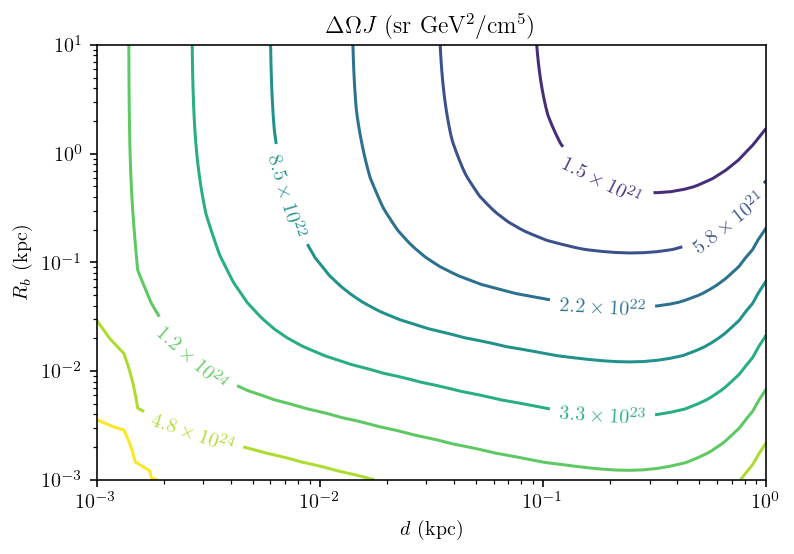

In [100]:
# J_plateau_exp = 2*r_p_mg*kpc_to_cm*rho_max**2 * 2*np.pi/dOmega
J_plateau_exp = 2*np.pi / dOmega * 1 / dist_mg**2 * 4/3.*np.pi*r_p_mg**3 * rho_max**2 * kpc_to_cm

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$\Delta \Omega J$ (sr GeV$^2$/cm$^5$)")

sci_contours(dist_mg, r_s_mg, J_plateau_exp, plt.gca(), fmt="0.1f")

Comparing power law and exp. clump luminosities. These should be very close, but the power law ones are 4 times larger!!!

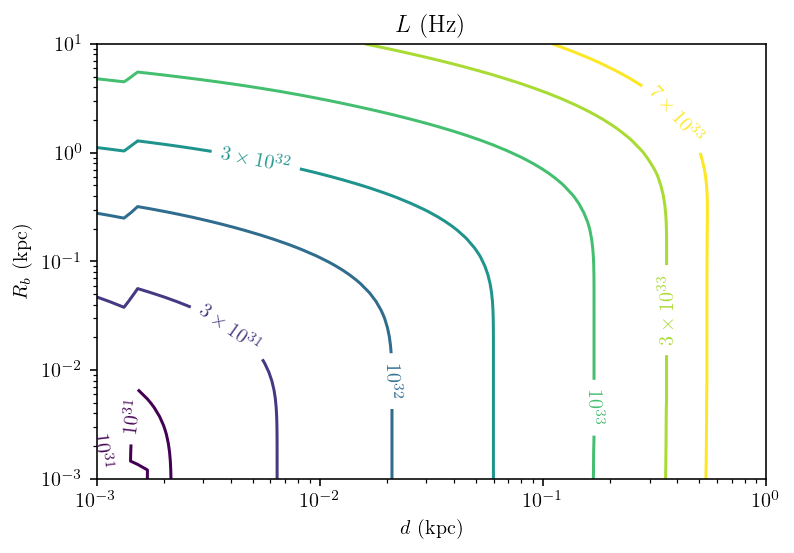

In [83]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$L$ (Hz)")

lums_pl = lum_pl(r_p_mg, r_tr_mg, gamma_exp)
sci_contours(dist_mg, r_s_mg, lums_pl/4, plt.gca(), levels_exp[gamma_exp]["lum"])

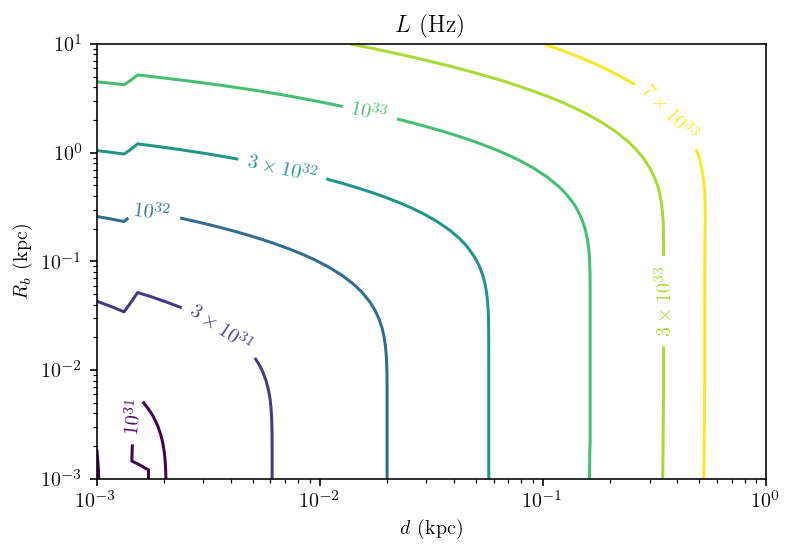

In [76]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$L$ (Hz)")

sci_contours(dist_mg, r_s_mg, lum_exp, plt.gca(), levels_exp[gamma_exp]["lum"])

# Extreme power law profile

When I set the inner slope $\nu$ to extreme values like $3/2$ or $9/4$, the calculation suffers from numerical issues. Instead, I will try computing the luminosity for a point source at a particular distance, and use Ben's estimate for the truncation radius to convert this to a density normalization for the halo.

Consistency check: the truncation radius needs to be large enough for the luminosity to match up with that of the point source.

In [90]:
from pointlike_clump import lum_dampe_pt, dphi_de_e_pt, phi_g_pt
from power_law_clump import line_width_constraint as line_width_constraint_pl
from power_law_clump import rho as rho_pl
from power_law_clump import ann_plateau_radius as ann_plateau_radius_pl
from power_law_clump import lum as lum_pl

ImportError: cannot import name bg_dampe

In [20]:
gamma_pl = 3/2.
dist = np.logspace(-3, 0, 50)
r_tr = np.logspace(-3, 1, 50)
dist_mg, r_tr_mg = np.meshgrid(dist, r_tr)

base_path_pl = 'data/pl_gamma_%.2f/' % gamma_pl

Point-source luminosities

In [21]:
lum_pt = lum_dampe_pt(dist)
lum_pt_grid = np.stack(r_tr.shape[0]*[lum_pt])
lum_pt_grid[lum_pt_grid < 0] = np.nan

pointlike_clump.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dampe_excess_bin_high, points=[mx], epsabs=0)[0]


Annihilation plateau radii

In [7]:
r_p = ann_plateau_radius_pl(r_tr_mg, lum_pt_grid, gamma_pl)

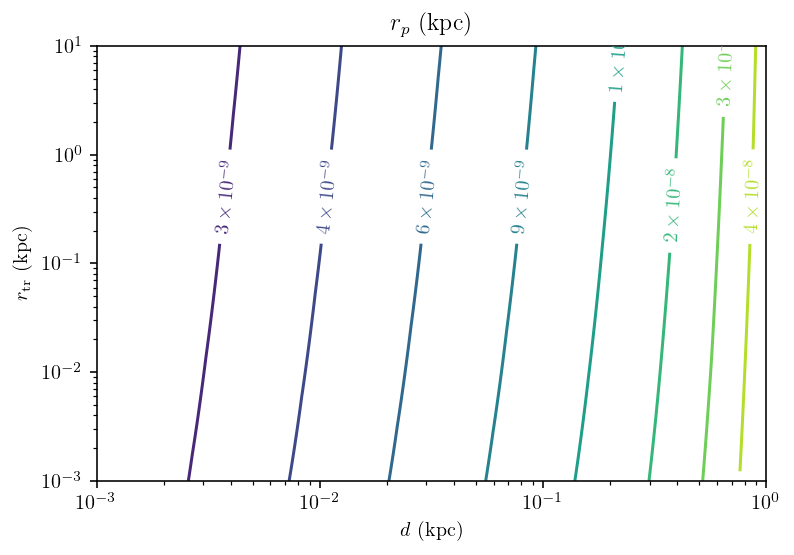

In [13]:
dist = np.logspace(-3, 0, 50)
r_tr = np.logspace(-3, 1, 50)
dist_mg, r_tr_mg = np.meshgrid(dist, r_tr)
# r_p = np.loadtxt("data/pl_gamma_1.50/r_p.csv", delimiter=',')

plt.title(r"$r_p$ (kpc)")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{tr}}$ (kpc)")
plt.xscale("log")
plt.yscale("log")

sci_contours(dist_mg, r_tr_mg, r_p, plt.gca())

Local density enhancement

In [8]:
rho_rel_pl = (rho_pl(dist_mg, r_p, r_tr_mg, gamma_pl) + rho_earth) / rho_earth

Line width constraint

In [9]:
lw_pt_grid = line_width_constraint_pl(dist_mg, r_p, r_tr_mg, gamma_pl)

power_law_clump.py:108: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  epsrel=1e-5)[0]


Gamma ray flux from point-like clump

In [10]:
phi_g_pt = phi_g_pt(e_gamma_ref, dist, dampe_excess_bin_high, lum_pt)
phi_g_pt_grid = np.stack(r_tr.shape[0]*[phi_g_pt])
phi_g_pt_grid[phi_g_pt_grid < 0] = np.nan

Gamma ray flux from power law clump

In [31]:
if gamma_pl == 9/4.:
    # Integrate out to a few times r_p. Taking a larger bound for this integration
    # doesn't impact J.
    r_cut_mg = fermi_psf * dist_mg  # 100*r_p
    J_factors = 1 / fermi_psf_solid_angle / dist_mg**2
    J_factors *= (4*np.pi/(9.-6.*gamma_pl) * rho_max**2 *
                  (3 * r_cut_mg**3 * (r_p / r_cut_mg)**(2*gamma_pl) - 2*gamma_pl*r_p**3)) * kpc_to_cm
elif gamma_pl == 3/2.:
    dist_Js, r_tr_Js, J_factors = np.loadtxt(
        base_path_pl + "d_rtr_j.csv", delimiter=",").T
#     dist_Js = np.unique(dist_Js)
#     r_tr_Js = np.unique(r_tr_Js)
#     J_factors = J_factors.reshape([dist_Js.size, r_tr_Js.size])
    
phi_g = (fermi_psf_solid_angle/(4*np.pi) *
             3e-26/(2*dampe_excess_bin_high**2) *
             dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) *
             J_factors)
phi_g[phi_g < 0] = np.nan

ValueError: zero-size array to reduction operation minimum which has no identity

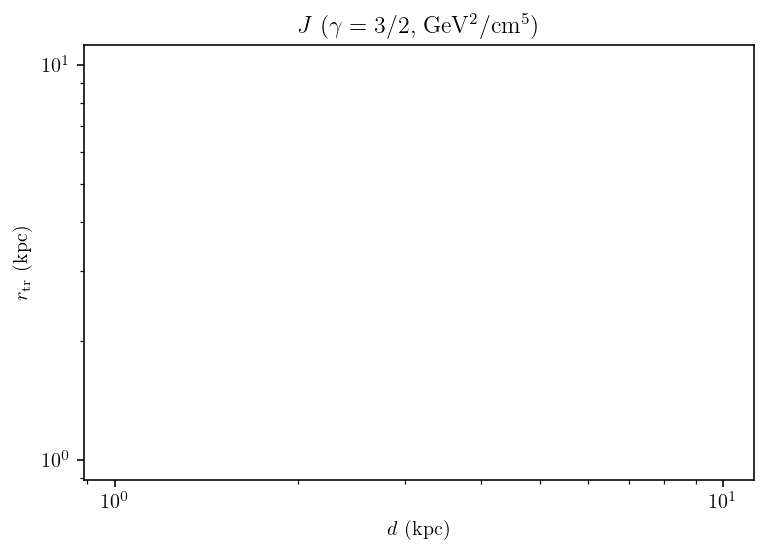

In [15]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$J$ ($\gamma=3/2$, GeV$^2$/cm$^5$)")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{tr}}$ (kpc)")

dist_Js, r_tr_Js, J_factors = np.loadtxt(base_path_pl + "d_rtr_j.csv", delimiter=",").T

sci_contours(dist_Js[:, 3:], r_tr_Js[:, 3:], J_factors[:, 3:] / rho_max**2, plt.gca())#, levels=log_levels(J_factors[:, 3:]))

# plt.savefig("/Users/acoogan/Desktop/J_3_2_pt_approx.pdf")

Point source gamma ray constraint

In [13]:
from utilities import fermi_pt_src_sens_120_45 as fermi_pt_src_sens
fermi_pt_src_sens(e_gamma_ref)

array(7.98754116e-15)

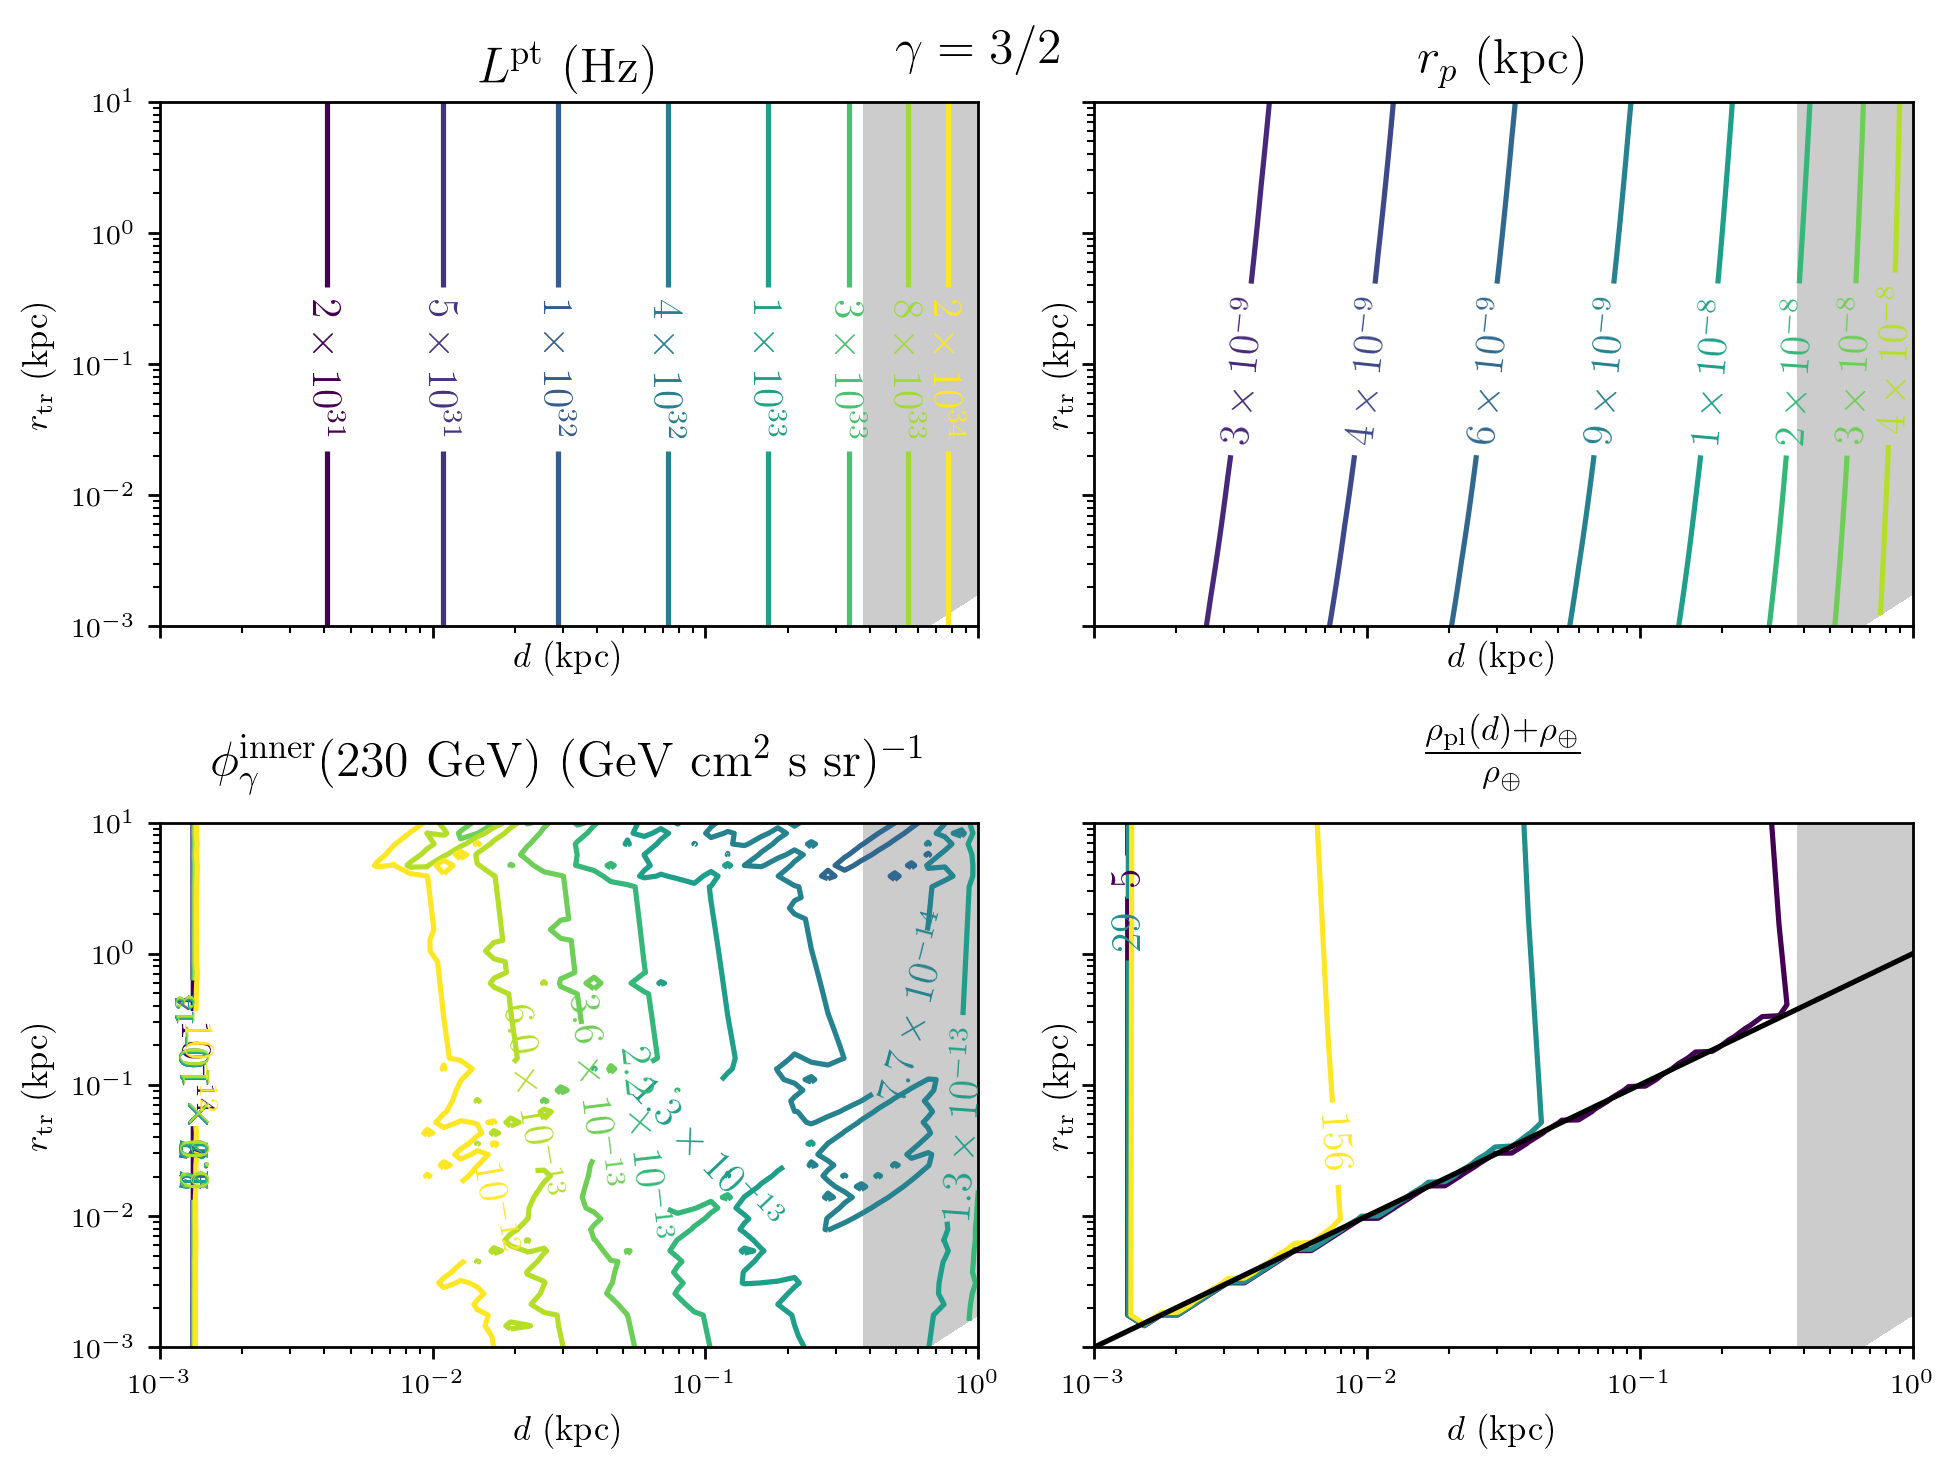

In [28]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(dist[[0, -1]])
    ax.set_ylim(r_tr[[0, -1]])
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_{\mathrm{tr}}$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_tr_mg, lw_pt_grid, levels=[n_sigma, np.max(lw_pt_grid)],
                colors='k', alpha=0.2)

ax = axs[0, 0]
ax.set_title(r"$L^{\mathrm{pt}}$ (Hz)")
sci_contours(dist_mg, r_tr_mg, lum_pt_grid, ax, levels=log_levels(lum_pt_grid))

ax = axs[0, 1]
ax.set_title(r"$r_p$ (kpc)")
sci_contours(dist_mg, r_tr_mg, r_p, ax, levels=log_levels(r_p))

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma^{\mathrm{inner}}(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
# sci_contours(dist_mg, r_tr_mg, phi_g_plateau, ax,
#              levels=log_levels(phi_g_plateau))
sci_contours(dist_mg, r_tr_mg, phi_g, ax, fmt="0.1f",
             levels=np.logspace(-14, -12, 10))

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{pl}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_tr_mg, rho_rel_pl, ax,
                levels=log_levels(rho_rel_pl, 5))
ax.plot(dist, dist, color='k')

fig.suptitle(r"$\gamma=3/2$")
fig.tight_layout()
fig.savefig("figures/contour_plots_pl_3_2.pdf")

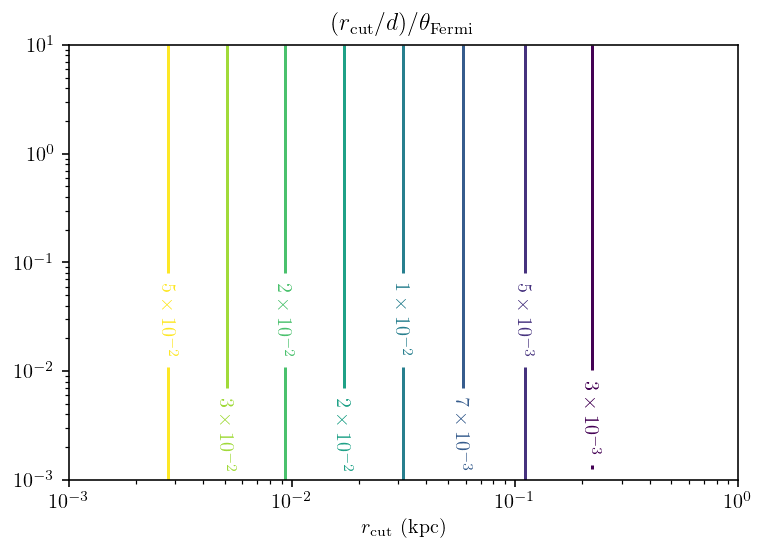

In [54]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.xlabel(r"$r_{\mathrm{cut}}$ (kpc)")
plt.title(r"$(r_{\mathrm{cut}} / d) / \theta_{\mathrm{Fermi}}$")
th_cut = r_cut_mg / dist_mg / fermi_psf
sci_contours(dist_mg, r_tr_mg, th_cut, plt.gca(), levels=log_levels(th_cut))

# Point-like clump

In [2]:
from utilities import D, speed_of_light, lambda_prop, kpc_to_cm
from pointlike_clump import dphi_de_e_dampe_pt, dphi_de_e_pt, lum_dampe_pt
from background_models import phi_e_bg_dampe

def aniso_pt(e, dist):
    lum = lum_dampe_pt(dist)
    
    def _aniso_pt(e):
        if e < mx:
            return np.abs((3 * D(e) / speed_of_light * 2 * dist / lambda_prop(e, mx) *
                           dphi_de_e_pt(e, dist, mx, lum) / phi_e_bg_dampe(e) * kpc_to_cm))
        else:
            return 0.
    
    return np.vectorize(_aniso_pt)(e)

In [10]:
e = 1e3
dist = 1e-1
r_s = 1e-2
gamma = 0.5
halo = "nfw"
delta_d_rel = 1e-4

rho_s_val = rho_s_dampe(dist, r_s, gamma, halo)
print("r_s = %.2e, gamma = %f, anisotropy = %.2e\n" %
      (r_s, gamma,
       anisotropy_differential(e, dist, r_s, rho_s_val, gamma, halo, delta_d_rel)))

# Plot point-like clump anisotropy
print("Point-like: anisotropy = %.2e\n" % np.abs(aniso_pt(e, dist)))

('dphi, dd = ', -2.6595396430159974e-20, 1e-05)
r_s = 1.00e-02, gamma = 0.500000, anisotropy = 9.21e-06

Point-like: anisotropy = 3.69e-05



gamma = 0.50, dist=1.00e-03
gamma = 0.50, dist=1.00e-02
gamma = 0.50, dist=1.00e-01
gamma = 0.50, dist=3.00e-01
gamma = 1.00, dist=1.00e-03
gamma = 1.00, dist=1.00e-02
gamma = 1.00, dist=1.00e-01
gamma = 1.00, dist=3.00e-01


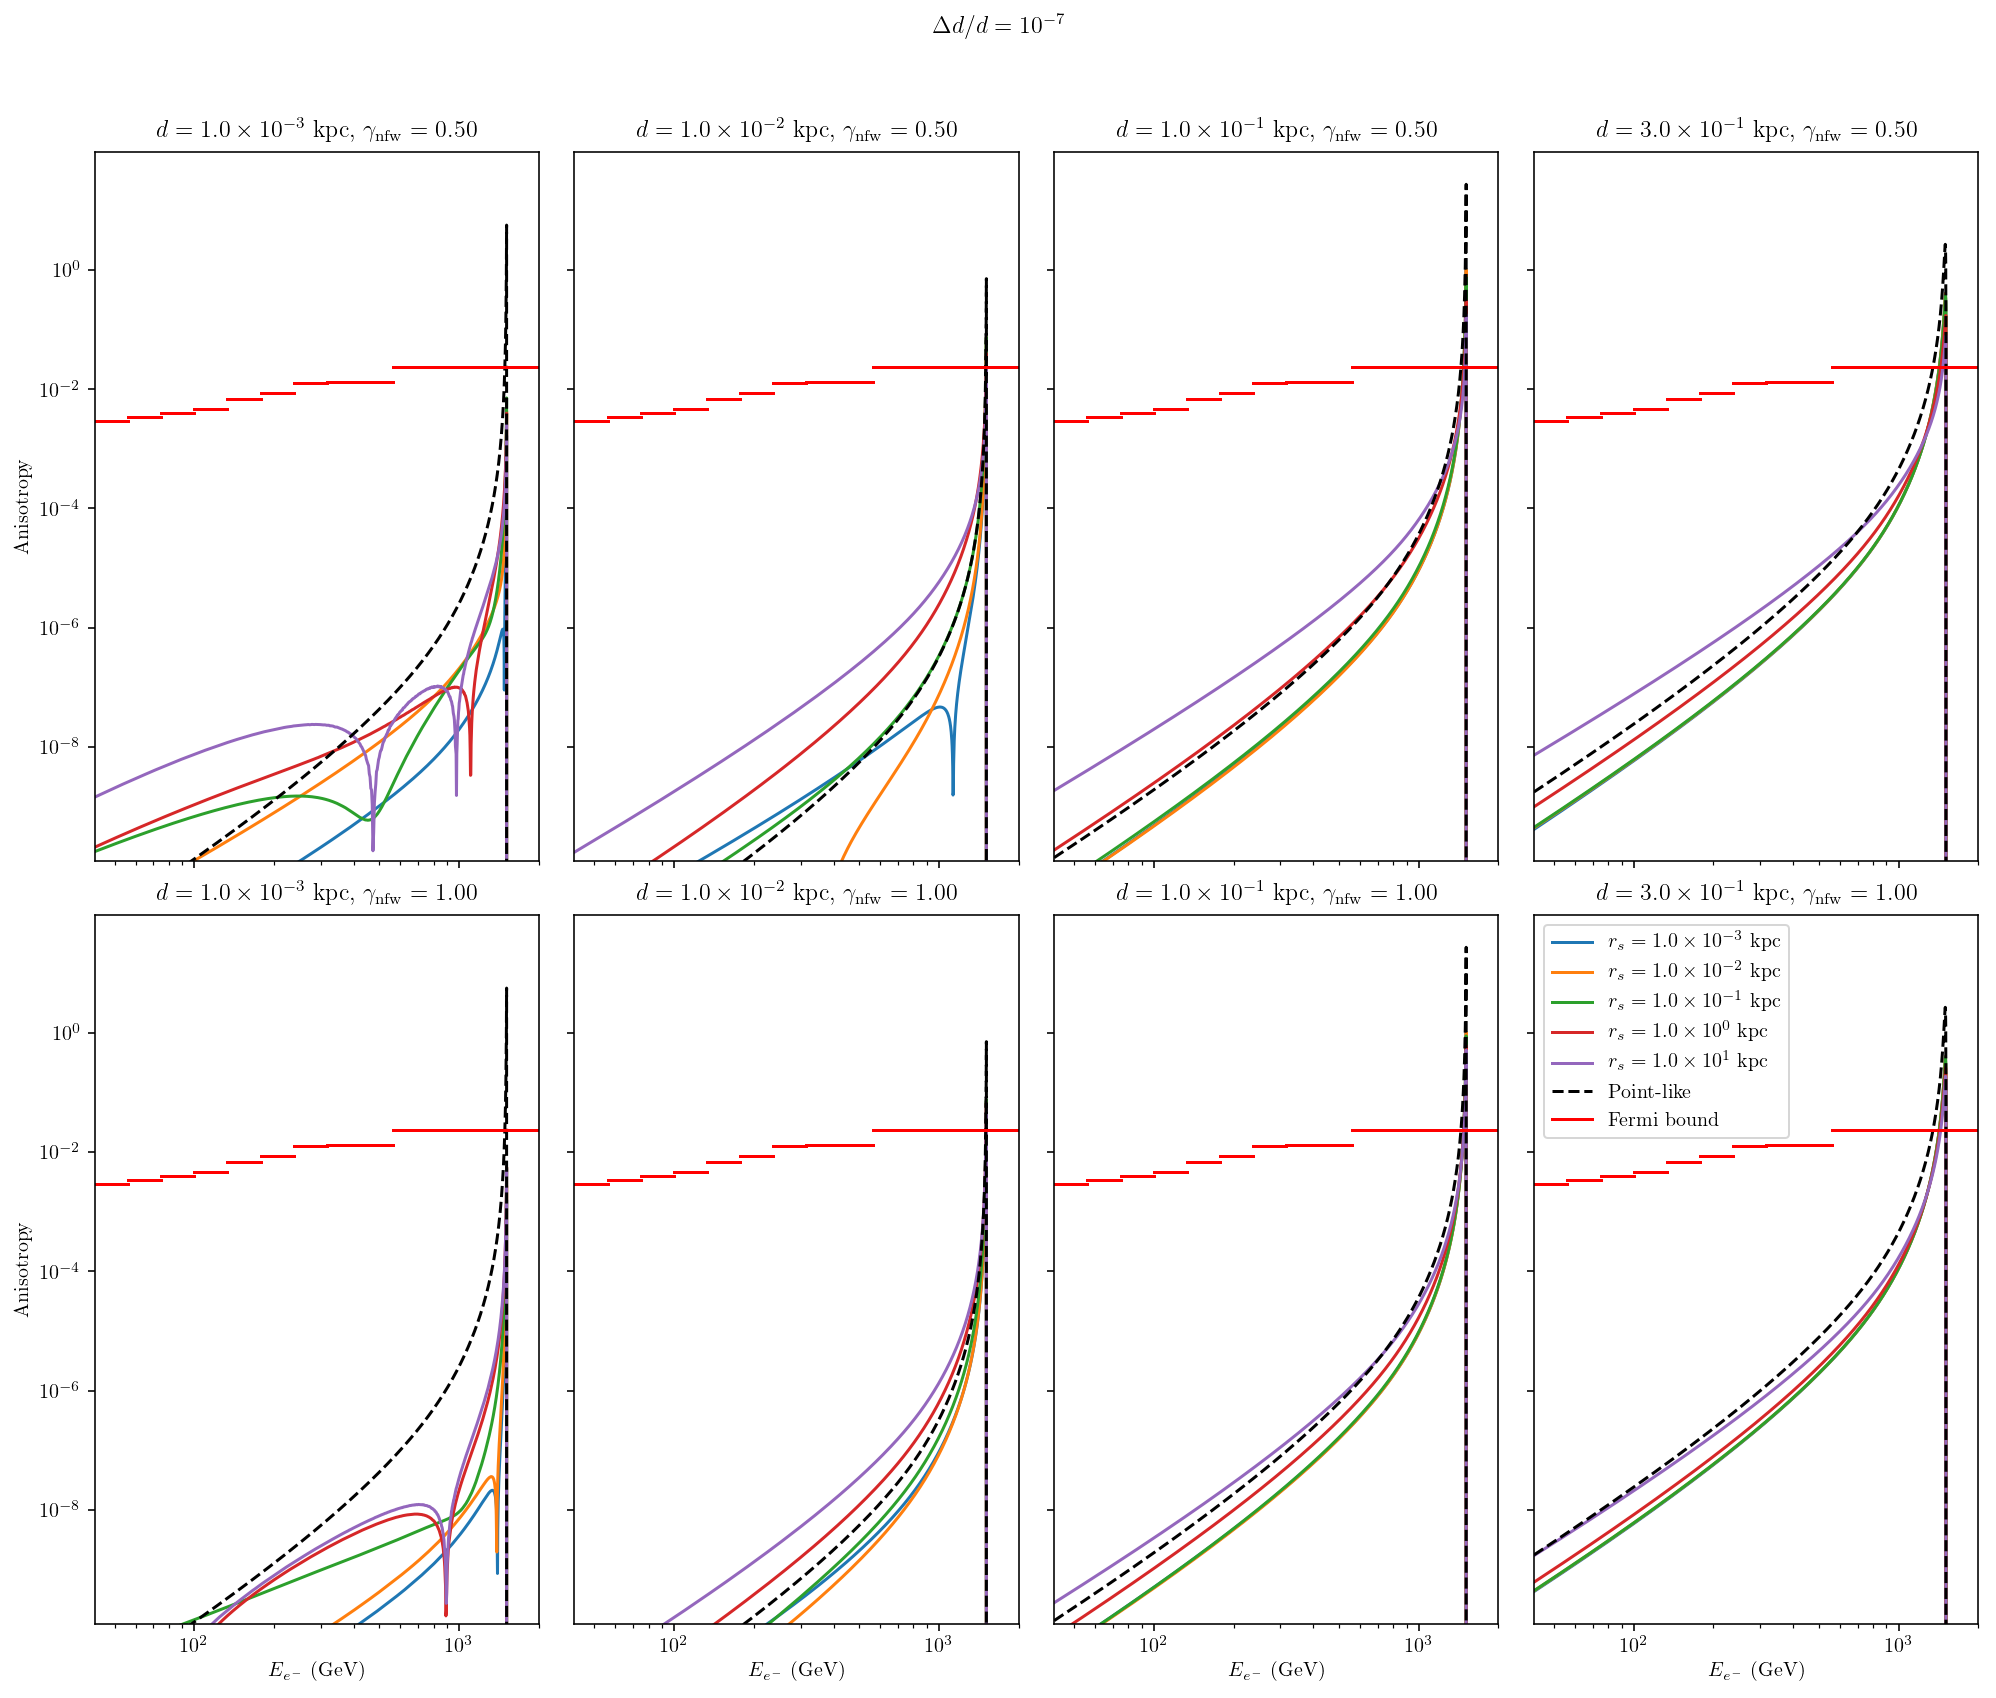

In [5]:
es = np.linspace(e_low_aniso_fermi[0], np.min([mx, e_high_aniso_fermi[-1]]), 500)
dists = np.array([1e-3, 1e-2, 1e-1, 0.3])
halo = "nfw"
gammas = np.array([0.5, 1.])#, 0.72, 1.08])
delta_d_rel = 1e-7

fig, axes = plt.subplots(len(gammas), len(dists), sharex=True, sharey=True,
                         figsize=(14, 12))

for i, gamma in enumerate(gammas):
    for j, dist in enumerate(dists):
        print("gamma = %.2f, dist=%.2e" % (gamma, dist))
        ax = axes[i, j]
        
        # Plot clump anisotropies
        for r_s in np.logspace(-3, 1, 5):
            rho_s_val = rho_s_dampe(dist, r_s, gamma, halo)
            ax.loglog(
                es, anisotropy_differential(es, dist, r_s, rho_s_val, gamma, halo, delta_d_rel),
                label=r"$r_s = %.1f \times 10^{%i}$ kpc" % mantissa_exp(r_s))

        # Plot point-like clump anisotropy
        ax.plot(es, aniso_pt(es, dist), '--k', label="Point-like")
        # Plot Fermi's upper bound
        for k, (e_low, e_high, aniso) in enumerate(zip(e_low_aniso_fermi,
                                                       e_high_aniso_fermi,
                                                       aniso_fermi)):
            if k == 0:
                label = "Fermi bound"
            else:
                label = None
            ax.plot([e_low, e_high], 2*[aniso], 'r', label=label)

        if i == len(gammas) - 1 and j == len(dists) - 1:
            ax.legend()
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(e_low_aniso_fermi[0], e_high_aniso_fermi[-1])
        ax.set_ylim(1e-10, 1e2)
        if i == len(gammas) - 1:
            ax.set_xlabel(r"$E_{e^-}$ (GeV)")
        if j == 0:
            ax.set_ylabel(r"Anisotropy")
        ax.set_title(r"$d = %.1f \times 10^{%i}$ kpc, $\gamma_{\mathrm{%s}} = %.2f$" %
                     (mantissa_exp(dist)[0], mantissa_exp(dist)[1], halo, gamma))

fig.suptitle(r"$\Delta d / d = 10^{%i}$" % mantissa_exp(delta_d_rel)[1])
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.savefig("figures/aniso_diff_%s_delta_d_rel=%s.pdf" % (halo, str(delta_d_rel)))

gamma = 0.54, dist=1.00e-01


finite_clump_vectorized.py:139: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  epsabs=0, epsrel=epsrel, limit=limit)


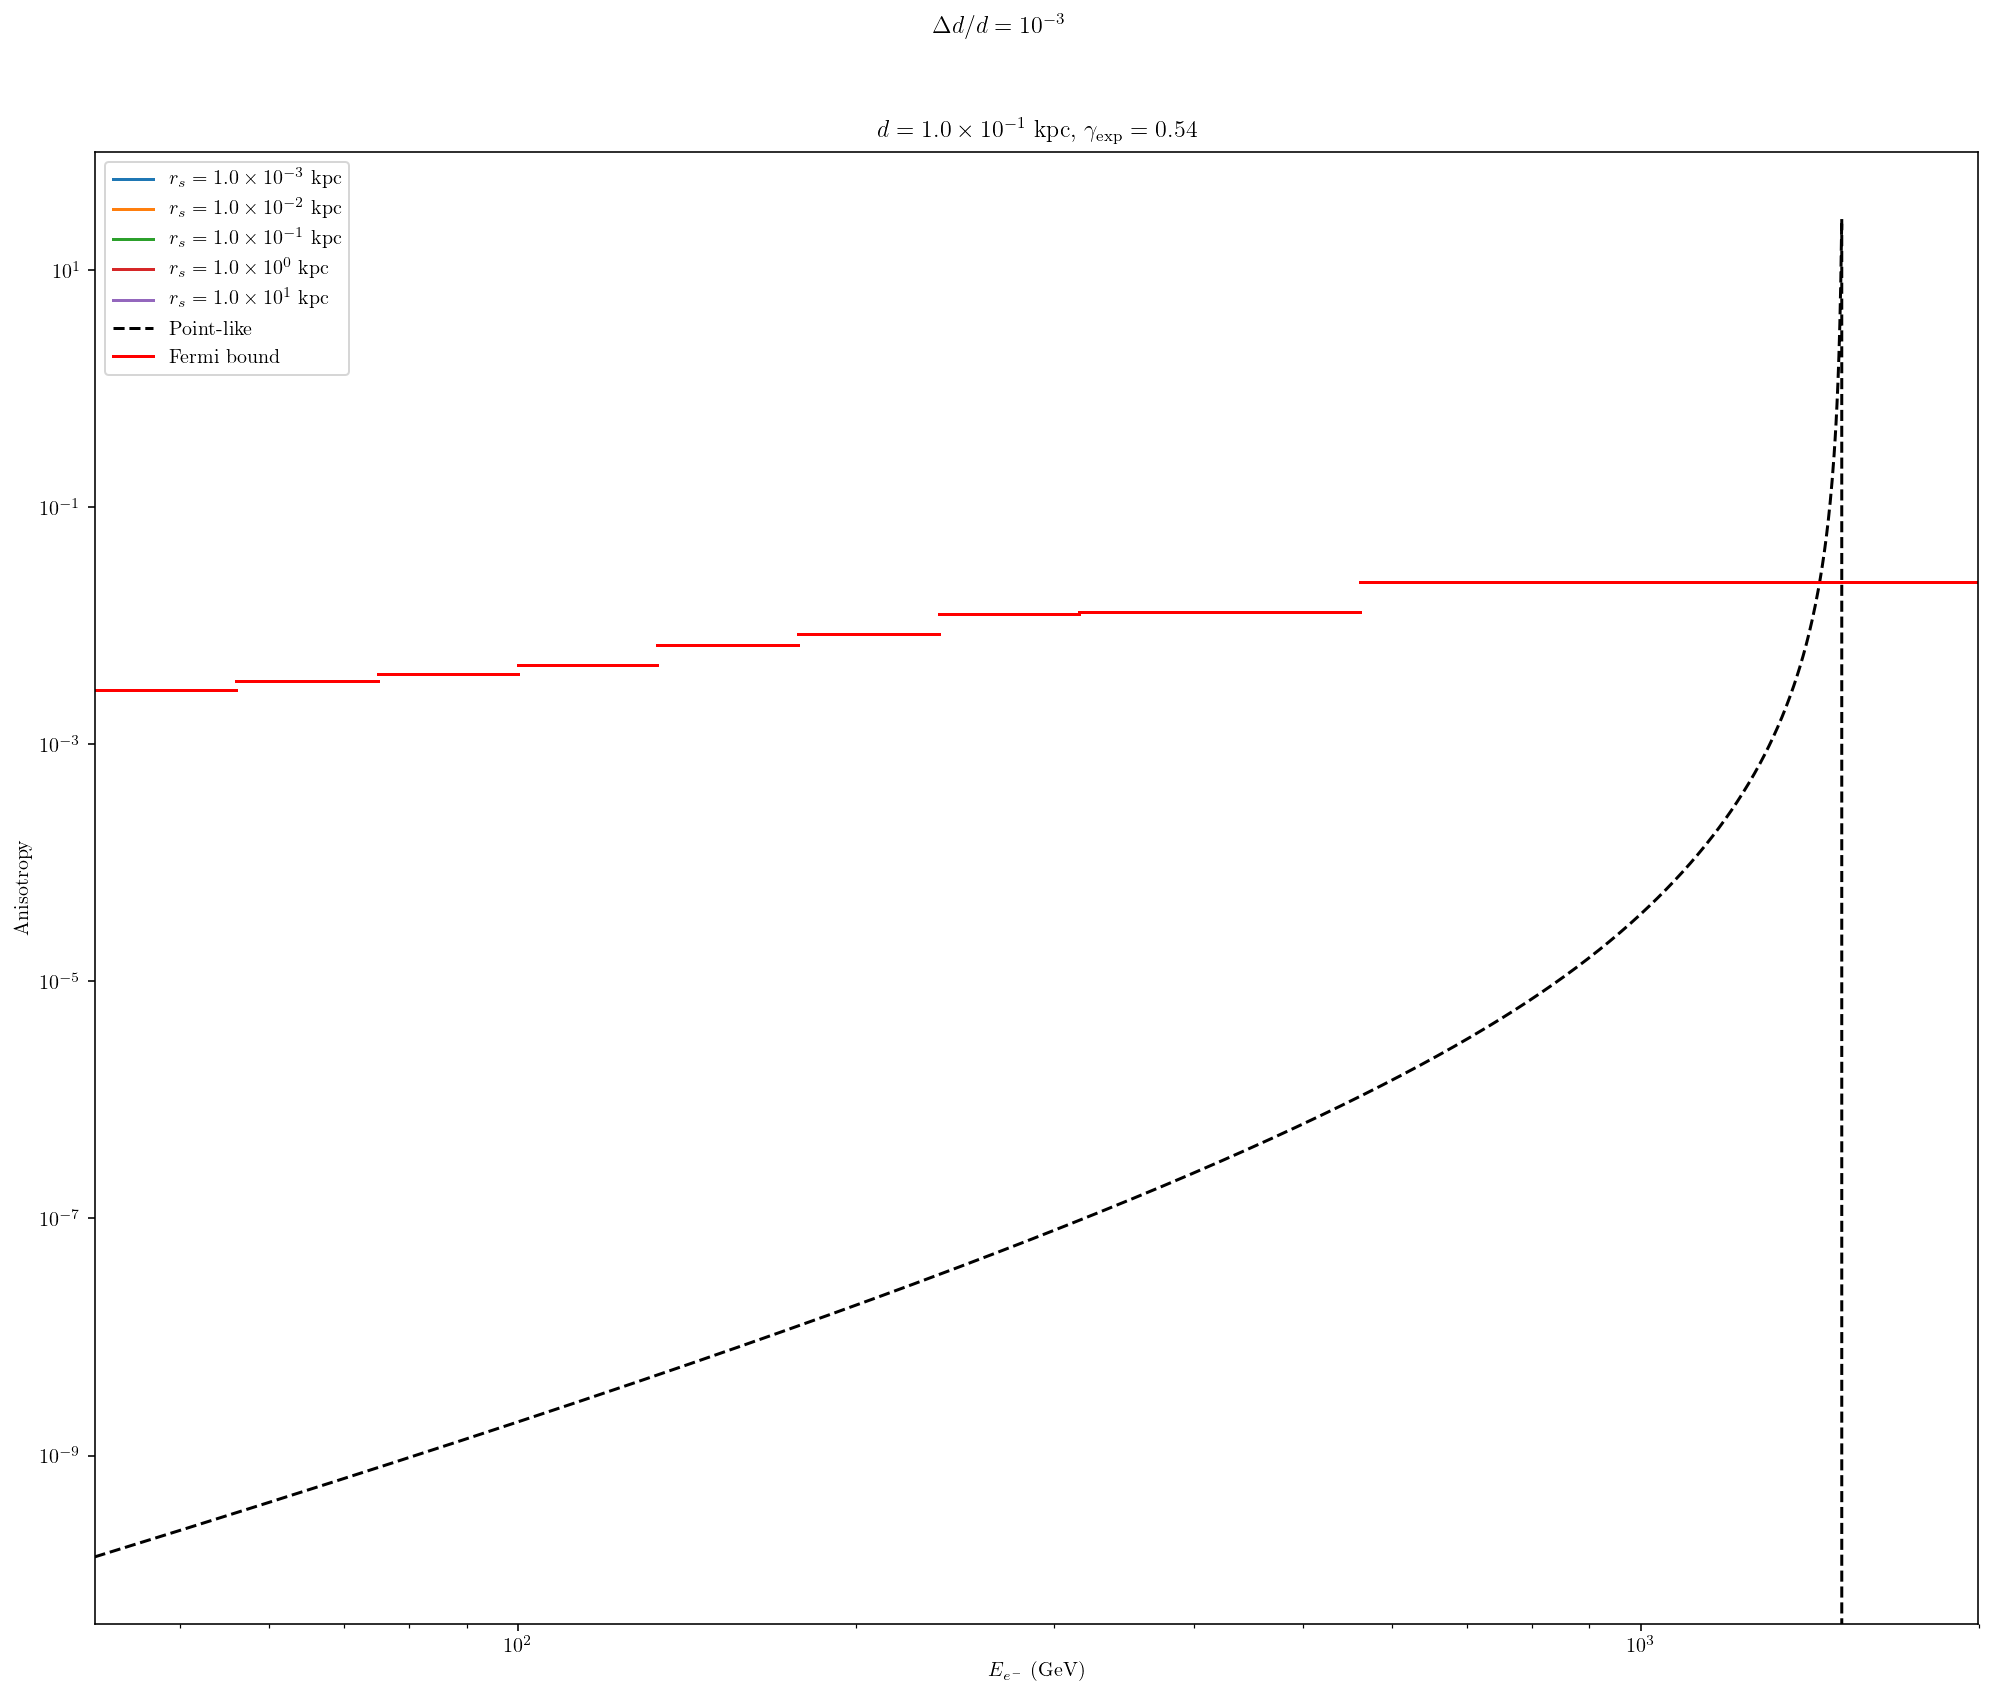

In [15]:
es = np.linspace(e_low_aniso_fermi[0], np.min([mx, e_high_aniso_fermi[-1]]), 500)
dists = np.array([1e-1])#, 1e-2, 1e-1, 0.3])
halo = "exp"
gammas = np.array([0.54])#, 0.72, 1.08])
delta_d_rel = 1e-3

fig, axes = plt.subplots(len(gammas), len(dists), sharex=True, sharey=True,
                         figsize=(14, 12))

for i, gamma in enumerate(gammas):
    for j, dist in enumerate(dists):
        print("gamma = %.2f, dist=%.2e" % (gamma, dist))
        ax = axes#[i, j]
        
        # Plot clump anisotropies
        for r_s in np.logspace(-3, 1, 5):
            rho_s_val = rho_s_dampe(dist, r_s, gamma, halo)
            ax.loglog(
                es, anisotropy_differential(es, dist, r_s, rho_s_val, gamma, halo, delta_d_rel),
                label=r"$r_s = %.1f \times 10^{%i}$ kpc" % mantissa_exp(r_s))

        # Plot point-like clump anisotropy
        ax.plot(es, aniso_pt(es, dist), '--k', label="Point-like")
        # Plot Fermi's upper bound
        for k, (e_low, e_high, aniso) in enumerate(zip(e_low_aniso_fermi,
                                                       e_high_aniso_fermi,
                                                       aniso_fermi)):
            if k == 0:
                label = "Fermi bound"
            else:
                label = None
            ax.plot([e_low, e_high], 2*[aniso], 'r', label=label)

        if i == len(gammas) - 1 and j == len(dists) - 1:
            ax.legend()
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(e_low_aniso_fermi[0], e_high_aniso_fermi[-1])
        ax.set_ylim(1e-10, 1e2)
        if i == len(gammas) - 1:
            ax.set_xlabel(r"$E_{e^-}$ (GeV)")
        if j == 0:
            ax.set_ylabel(r"Anisotropy")
        ax.set_title(r"$d = %.1f \times 10^{%i}$ kpc, $\gamma_{\mathrm{%s}} = %.2f$" %
                     (mantissa_exp(dist)[0], mantissa_exp(dist)[1], halo, gamma))

fig.suptitle(r"$\Delta d / d = 10^{%i}$" % mantissa_exp(delta_d_rel)[1])
fig.tight_layout()
fig.subplots_adjust(top=0.90)
# fig.savefig("figures/aniso_diff_%s_delta_d_rel=%s.pdf" % (halo, str(delta_d_rel)))

In [13]:
from exp_clump import ann_plateau_radius

@np.vectorize
def rho(dist, Rb, rho0, gamma):
    r_p = ann_plateau_radius(Rb, rho0, gamma)
    if dist < r_p:
        return rho_max
    else:
        return rho0 * (Rb / dist)**gamma * np.exp(-dist / Rb)

In [32]:
np.logspace(np.log10(1e-3 * r_s), np.log10(10 * r_s), 20)

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

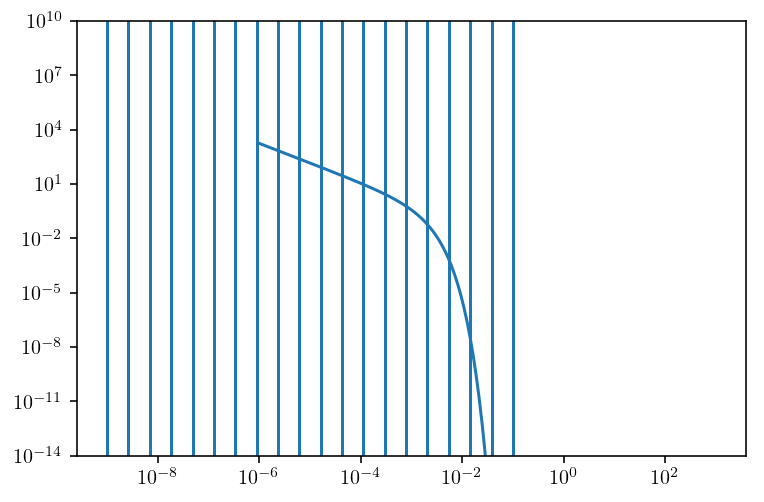

In [42]:
rs = np.logspace(-6, 3, 300)
r_s = 1e-3

plt.loglog(rs, rho(rs, r_s, 1., 1.08))
plt.ylim(1e-14, 1e10)
for r_sample in np.logspace(np.log10(1e-6 * r_s), np.log10(100 * r_s), 20):
    plt.axvline(r_sample)

0.1



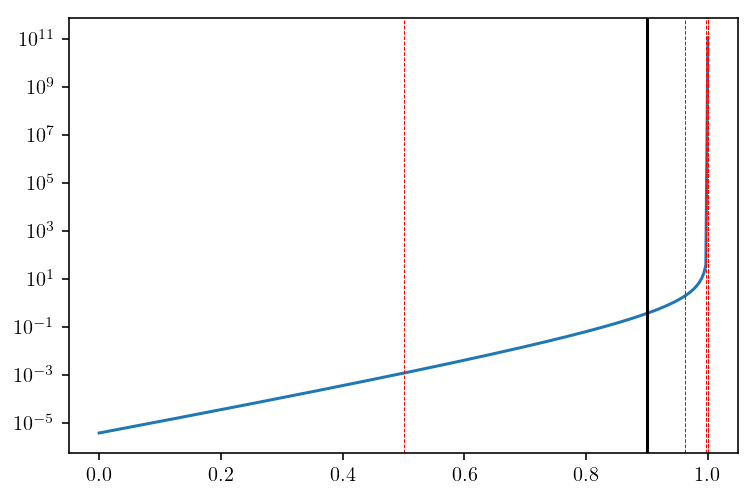

In [101]:
dist = 1e0
r_s = 0.1

print(r_s / dist)
print("")

if r_s / dist > 1:
    samples = dist - np.logspace(-6, np.log10(0.5), 7) * dist
else:
    samples = dist - np.logspace(np.log10(1e-6 * r_s), np.log10(min(1e2 * r_s, 0.5 * dist)), 7)

rs = np.linspace(0, dist, 300)
plt.plot(rs, rho(dist - rs, r_s, 1., 1.08))
plt.axvline(dist - r_s, color='k')

for s in samples:
    plt.axvline(s, color='r', linestyle='--', linewidth=0.5)

plt.yscale("log")

In [102]:
samples

array([0.9999999 , 0.99999869, 0.9999829 , 0.99977639, 0.99707598,
       0.96176378, 0.5       ])

In [100]:
samples

array([0.99999999, 0.99999981, 0.99999634, 0.99992964, 0.99864733,
       0.97399356, 0.5       ])

In [98]:
samples

array([0.99999999, 0.99999981, 0.99999632, 0.99992929, 0.99864279,
       0.97394996, 0.5       ])

Integration warnings:
* gamma = 0.54, dist=3.00e-01
* gamma = 1.08, dist=1.00e-03
* gamma = 1.08, dist=1.00e-02
* gamma = 1.08, dist=1.00e-01

In [4]:
e = 1e3
dists = np.array([1e-1])
halo = "exp"
gammas = np.array([0.72])
delta_d_rel = 1e-8

for i, gamma in enumerate(gammas):
    for j, dist in enumerate(dists):
        # Plot clump anisotropies
        for r_s in np.logspace(-3, 1, 5):
            rho_s_val = rho_s_dampe(dist, r_s, gamma, halo)
            print("r_s = %.2e, gamma = %f, anisotropy = %.2e\n" %
                  (r_s, gamma,
                   anisotropy_differential(e, dist, r_s, rho_s_val, gamma, halo, delta_d_rel)))

        # Plot point-like clump anisotropy
        print("Point-like: anisotropy = %.2e\n" % np.abs(aniso_pt(e, dist)))

('dphi, dd = ', 4.1467581043653416e-23, 1e-09)
r_s = 1.00e-03, gamma = 0.720000, anisotropy = 1.44e-04

('dphi, dd = ', -2.4266181859939753e-24, 1e-09)
r_s = 1.00e-02, gamma = 0.720000, anisotropy = -8.40e-06

('dphi, dd = ', -2.9205397759709552e-24, 1e-09)
r_s = 1.00e-01, gamma = 0.720000, anisotropy = -1.01e-05

('dphi, dd = ', 4.254286850831804e-22, 1e-09)
r_s = 1.00e+00, gamma = 0.720000, anisotropy = 1.46e-03

('dphi, dd = ', 1.6797567402379095e-21, 1e-09)
r_s = 1.00e+01, gamma = 0.720000, anisotropy = 5.75e-03

Point-like: anisotropy = 3.69e-05



In [36]:
os.system("say 'Done'")

0

In [4]:
dist = 1e-1
r_s = 1e-2
gamma = 0.5
halo = "exp"

rho_s = rho_s_dampe(dist, r_s, gamma, halo)

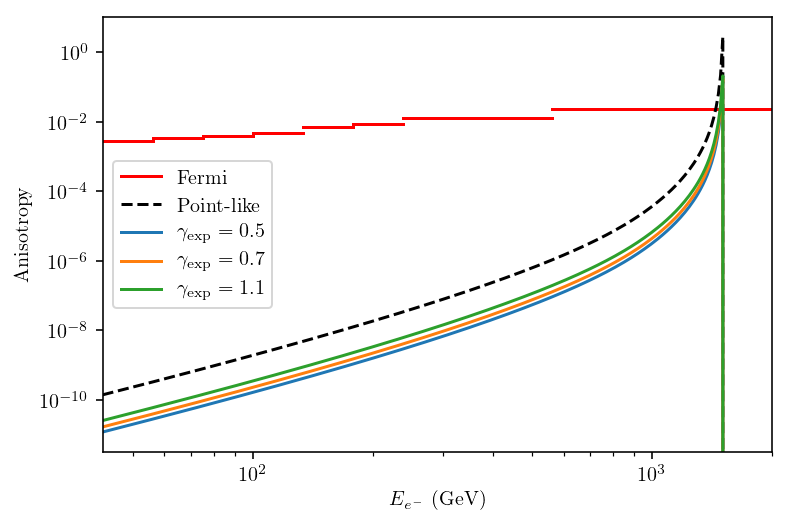

In [45]:
es = np.logspace(np.log10(e_low_aniso_fermi[0]), np.log10(e_high_aniso_fermi[-1]), 300)

plt.xscale("log")
plt.yscale("log")
plt.autoscale(enable=True, axis="x", tight=True)
plt.xlabel(r"$E_{e^-}$ (GeV)")
plt.ylabel("Anisotropy")

for i, (e_low, e_high, aniso) in enumerate(zip(e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi)):
    if i == 0:
        label = "Fermi"
    else:
        label = None
    plt.plot([e_low, e_high], 2*[aniso], 'r', label=label)

plt.plot(es, aniso_pt(es, dist), '--k', label="Point-like")

halo = "exp"
# for gamma in [0.5, 1.]:
for gamma in [0.52, 0.74, 1.08]:
    rho_s = rho_s_dampe(dist, r_s, gamma, halo)
    plt.plot(es, aniso_nfw(es, dist, r_s, rho_s, gamma, delta_d_rel=0.01),
             label=r"$\gamma_{\mathrm{%s}} = %.1f$" % (halo, gamma))

plt.legend()